# Dataset

 This dataset contains 515,738 customer reviews and scoring of 1493 Luxury Hotels across Europe. The csv file contains 17 fields. The description of each field is as below:

Hotel_Address: Address of hotel.
    
Review_Date: Date when reviewer posted the corresponding review.
    
Average_Score: Average Score of the hotel, calculated based on the latest comment in the last year.
    
Hotel_Name: Name of Hotel
    
Reviewer_Nationality: Nationality of Reviewer
    
Negative_Review: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
        
Review_Total_Negative_Word_Counts: Total number of words in the negative review.
    
Positive_Review: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
        
Review_Total_Positive_Word_Counts: Total number of words in the positive review.
    
Reviewer_Score: Score the reviewer has given to the hotel, based on his/her experience
    
Total_Number_of_Reviews_Reviewer_Has_Given: Number of Reviews the reviewers has given in the past.
    
Total_Number_of_Reviews: Total number of valid reviews the hotel has.
    
Tags: Tags reviewer gave the hotel.
    
days_since_review: Duration between the review date and scrape date.
    
Additional_Number_of_Scoring: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
    
lat: Latitude of the hotel
    
lng: longtitude of the hotel
    


**Importing Libraries**

In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import string
from collections import Counter
import nltk
import re
import random 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import WhitespaceTokenizer
import folium 
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from matplotlib.colors import LinearSegmentedColormap
import missingno as msno
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib import pyplot
import seaborn as sns
from wordcloud import WordCloud
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Cleaning

In [3]:
df = pd.read_csv('Hotel_Reviews.csv')

In [4]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [5]:
df.shape

(515738, 17)

In [6]:
df['Reviewer_Nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Palau                             1
 Cape Verde                        1
 Anguilla                          1
 Vatican City                      1
Name: Reviewer_Nationality, Length: 227, dtype: int64

In [7]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

As the first step of the data cleaning, we are checking the duplicate rows and removing them:

In [8]:
# remove duplicates
print(sum(df.duplicated()))

526


In [9]:
df = df.drop_duplicates()

Secondly, we will handle the missing value. Let's first visualise how the missing values are distributed within the dataframe. By running the function below, we see that the missing values are found for the latitude and longitude features of the dataframe, towards the last rows

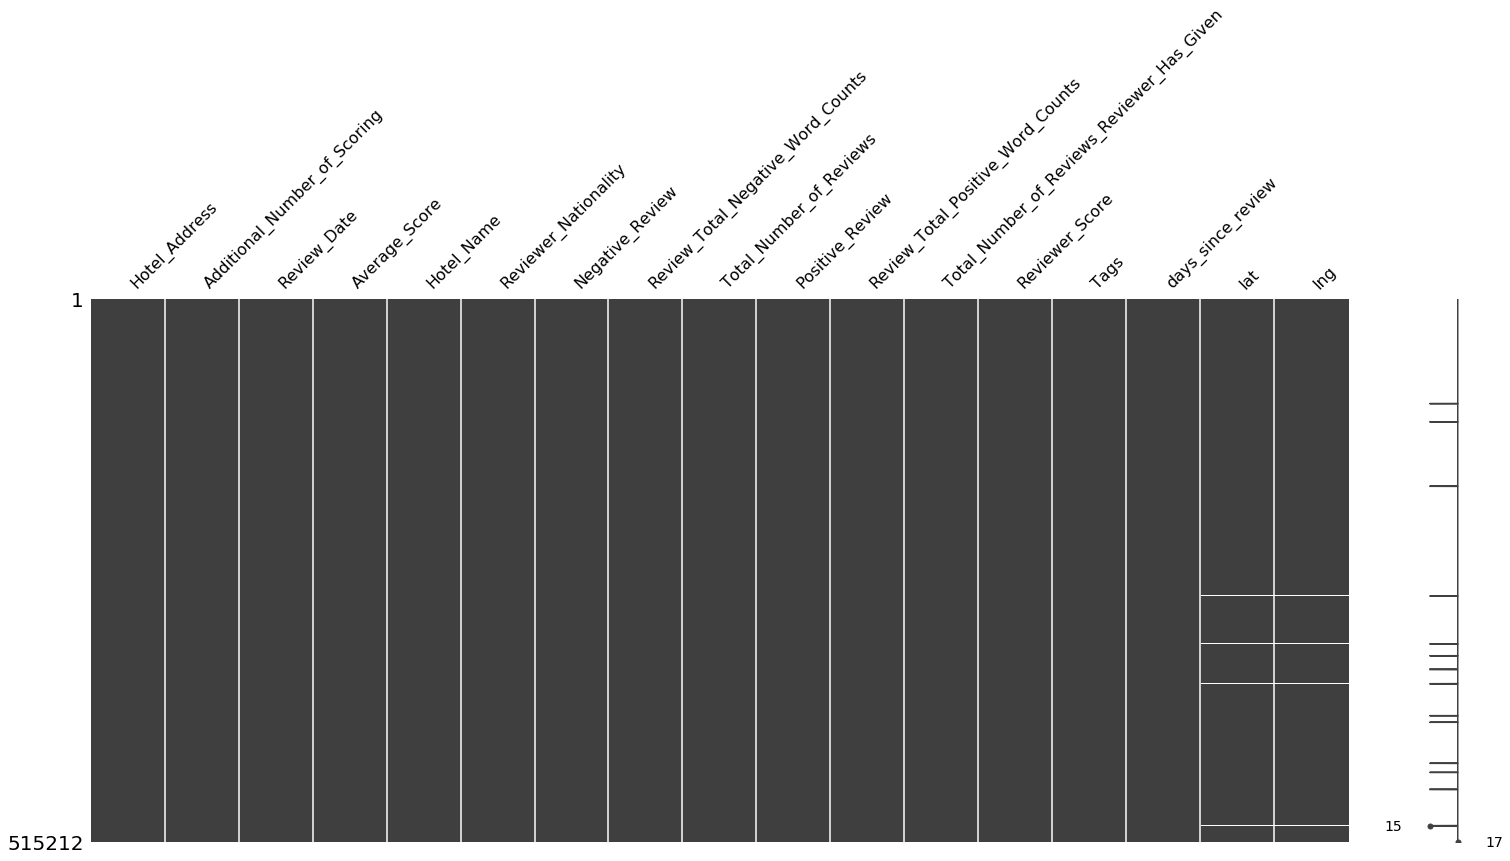

In [10]:
msno.matrix(df)

In [11]:
df.isnull().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64

As we would like to explore further, we would like to see for which hotels, the latitude and longitude values are missing:

In [12]:
nans = lambda df: df[df.isnull().any(axis = 1 )]
nans_df = nans(df)
nans_df = nans_df[['Hotel_Name', 'lat', 'lng']]
nans_df.Hotel_Name.describe()

count                                    3268
unique                                     17
top       Fleming s Selection Hotel Wien City
freq                                      658
Name: Hotel_Name, dtype: object

In [13]:
nans_df.Hotel_Name.value_counts()

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: Hotel_Name, dtype: int64

As we have only 17 unique hotels whose latitude and longitude are missing, the missing latitude and longitude values for them are found manually from google. A dictionary loc_lat and loc_lng are created for them. Finally, the missing lat and lng values in our dataframe are filled in by extracting the relevant futures from the dictionary that we have created:

In [14]:
#latitude information of Hotels
loc_lat = {'Fleming s Selection Hotel Wien City':48.209270,
       'Hotel City Central':48.2136,
       'Hotel Atlanta':48.210033,
       'Maison Albar Hotel Paris Op ra Diamond':48.875343,
       'Hotel Daniel Vienna':48.1888,
       'Hotel Pension Baron am Schottentor':48.216701,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':48.2195,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':48.245998,
      'NH Collection Barcelona Podium':41.3916,
      'City Hotel Deutschmeister':48.22088,
      'Hotel Park Villa':48.233577,
      'Cordial Theaterhotel Wien':48.209488,
      'Holiday Inn Paris Montmartre':48.888920,
      'Roomz Vienna':48.186605,
      'Mercure Paris Gare Montparnasse':48.840012,
      'Renaissance Barcelona Hotel':41.392673,
      'Hotel Advance':41.383308}

#longitude information of Hotels
loc_lng ={'Fleming s Selection Hotel Wien City':16.353479,
       'Hotel City Central':16.3799,
       'Hotel Atlanta':16.363449,
       'Maison Albar Hotel Paris Op ra Diamond':2.323358,
       'Hotel Daniel Vienna':16.3840,
       'Hotel Pension Baron am Schottentor':16.359819,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':16.2856,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':16.341080,
      'NH Collection Barcelona Podium':2.1779,
      'City Hotel Deutschmeister':16.36663,
      'Hotel Park Villa':16.345682,
      'Cordial Theaterhotel Wien':16.351585,
      'Holiday Inn Paris Montmartre':2.333087,
      'Roomz Vienna':16.420643,
      'Mercure Paris Gare Montparnasse':2.323595,
      'Renaissance Barcelona Hotel':2.167494,
      'Hotel Advance':2.162828}

#filling the latitude information
df['lat'] = df['lat'].fillna(df['Hotel_Name'].apply(lambda x: loc_lat.get(x)))
#filling longitude information
df['lng'] = df['lng'].fillna(df['Hotel_Name'].apply(lambda x: loc_lng.get(x)))

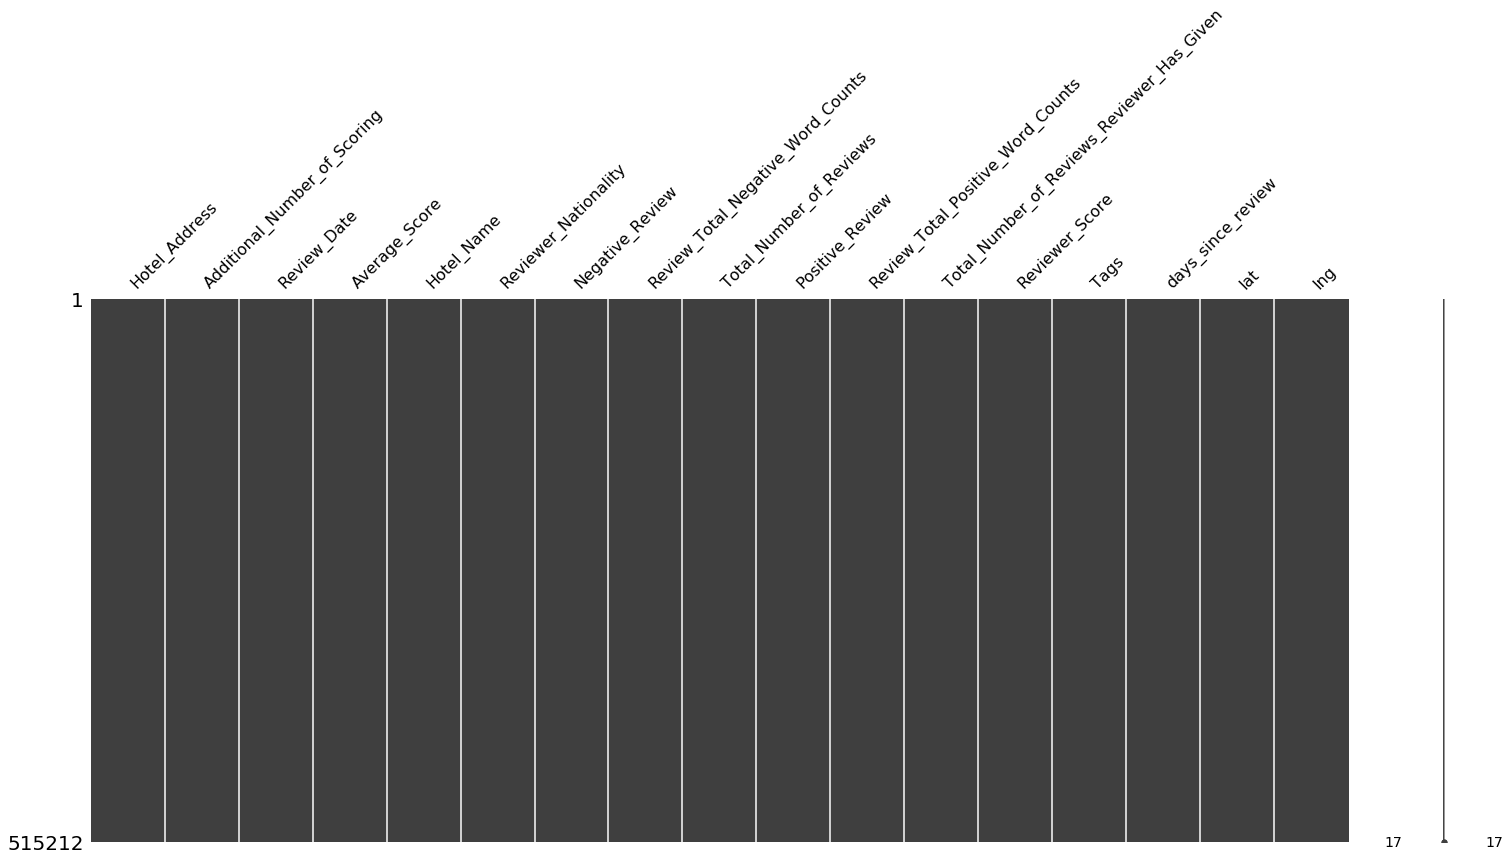

In [15]:
msno.matrix(df)

As can be seen above in the figure, we have succesfully replaced all the missing values

# 1. Exploratory Data Analysis for all the Hotels

In [16]:
df.Hotel_Name.describe()

count                                         515212
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: Hotel_Name, dtype: object

Text(0.5, 1.0, 'Top 20 Hotels By Popularity')

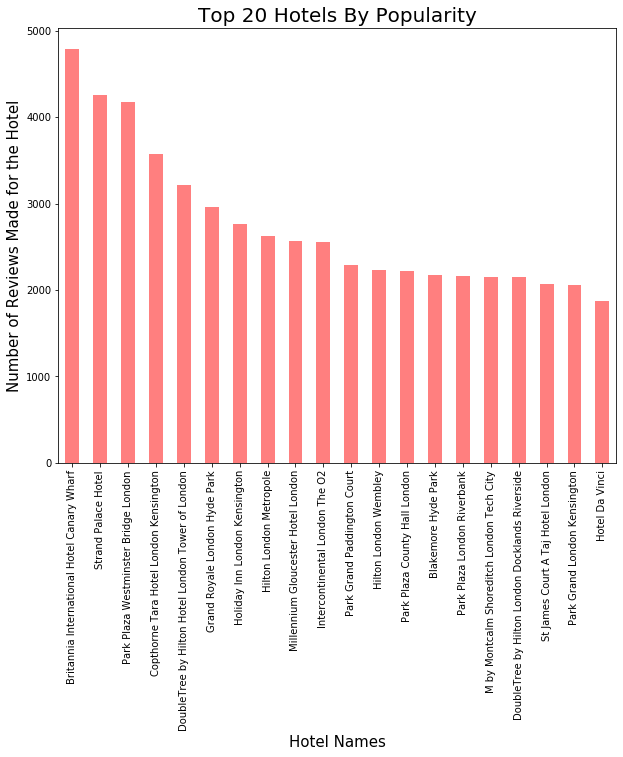

In [17]:
#Creating a plot for the top 20 hotels by popularity/review number
Hotel_Name_count = df.Hotel_Name.value_counts()
Hotel_Name_count[:20].plot(kind = 'bar', figsize = (10, 8), alpha=0.5, color='r')
plt.xlabel('Hotel Names', size=15)
plt.ylabel('Number of Reviews Made for the Hotel', size=15)
plt.title('Top 20 Hotels By Popularity', size=20)

#We will create a country column for the hotel:

In [18]:
#Creating country columns from the hotel adresses
country = df['Hotel_Address'].map(lambda x: x.split()[-1])
country = country.map(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df['hotel_country'] = country
df

Hotel_Address  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
...                                                   ...   
515733  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515734  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515735  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515736  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515737  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
0                                194    8/3/2017            7.7   
1                                194    8/3/2017            7.7   
2                                194   7/31/2017            7.7   
3                                194   7/31/2017            7.7   
4                                194   7/24/2017            7.7   
...                              ...         ...            ...   
515733                           168   8/30/2015            8.1   
515734                           168   8/22/2015            8.1   
515735                           168   8/19/2015            8.1   
515736                           168   8/17/2015            8.1   
515737                           168    8/9/2015            8.1   

                   Hotel_Name Reviewer_Nationality  \
0                 Hotel Arena              Russia    
1                 Hotel Arena             Ireland    
2                 Hotel Arena           Australia    
3                 Hotel Arena      United Kingdom    
4                 Hotel Arena         New Zealand    
...                       ...                  ...   
515733  Atlantis Hotel Vienna              Kuwait    
515734  Atlantis Hotel Vienna             Estonia    
515735  Atlantis Hotel Vienna               Egypt    
515736  Atlantis Hotel Vienna              Mexico    
515737  Atlantis Hotel Vienna             Hungary    

                                          Negative_Review  \
0        I am so angry that i made this post available...   
1                                             No Negative   
2        Rooms are nice but for elderly a bit difficul...   
3        My room was dirty and I was afraid to walk ba...   
4        You When I booked with your company on line y...   
...                                                   ...   
515733   no trolly or staff to help you take the lugga...   
515734           The hotel looks like 3 but surely not 4    
515735   The ac was useless It was a hot week in vienn...   
515736                                        No Negative   
515737       I was in 3rd floor It didn t work Free Wife    

        Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                     397                     1403   
1                                       0                     1403   
2                                      42                     1403   
3                                     210                     1403   
4                                     140                     1403   
...                                   ...                      ...   
515733                                 14                     2823   
515734                                 11                     2823   
515735                                 19                     2823   
515736                                  0                     2823   
515737                                 13                     2823   

                                          Positive_Review  \
0        Only the park outside of the hotel was beauti...   
1        No real complaints the hotel was great great ...   
2        Location was good and staff were ok It is cut...   
3        Great location in nice surroun

Text(0.5, 1.0, 'Countries Where Hotels Are Located')

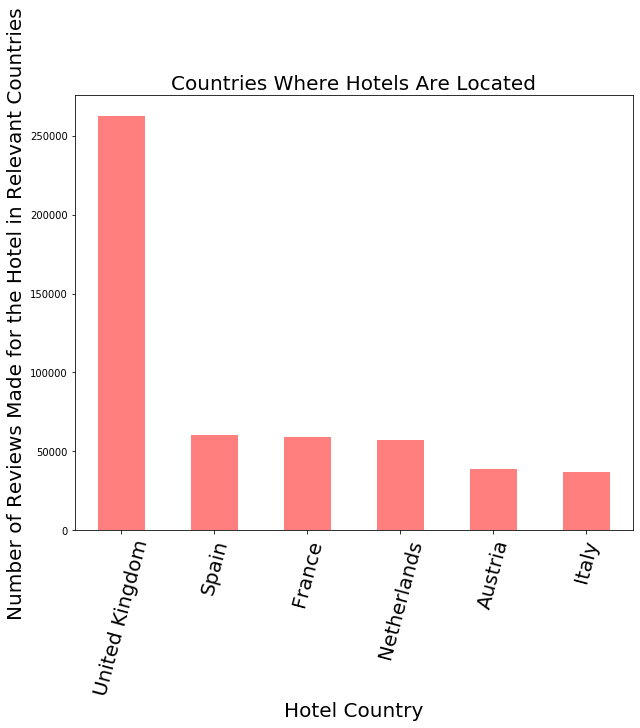

In [19]:
#Checking the countries where the hotels are located
Hotel_Country_count = df.hotel_country.value_counts()
Hotel_Country_count.plot(kind = 'bar', figsize = (10, 8), alpha=0.5, color='r')
plt.xlabel('Hotel Country', size=20)
plt.xticks(size=20, rotation=75)
plt.ylabel('Number of Reviews Made for the Hotel in Relevant Countries', size=20)
plt.title('Countries Where Hotels Are Located', size=20)

In [20]:
Creating a map for the locations where the hotels are located
map1 = folium.Map(location = [47, 6], zoom_start = 5, tiles = 'Stamen Toner')
df.apply(lambda row:folium.Marker(location=[row['lat'], row['lng']])
         .add_to(map1), axis = 1)
map1

As can be seen above, a very high majority of the reviews are made for the hotels that are located in the UK, which are all located in London.

Text(0.5, 1.0, 'Average Score Distribution of the Hotels in the Region')

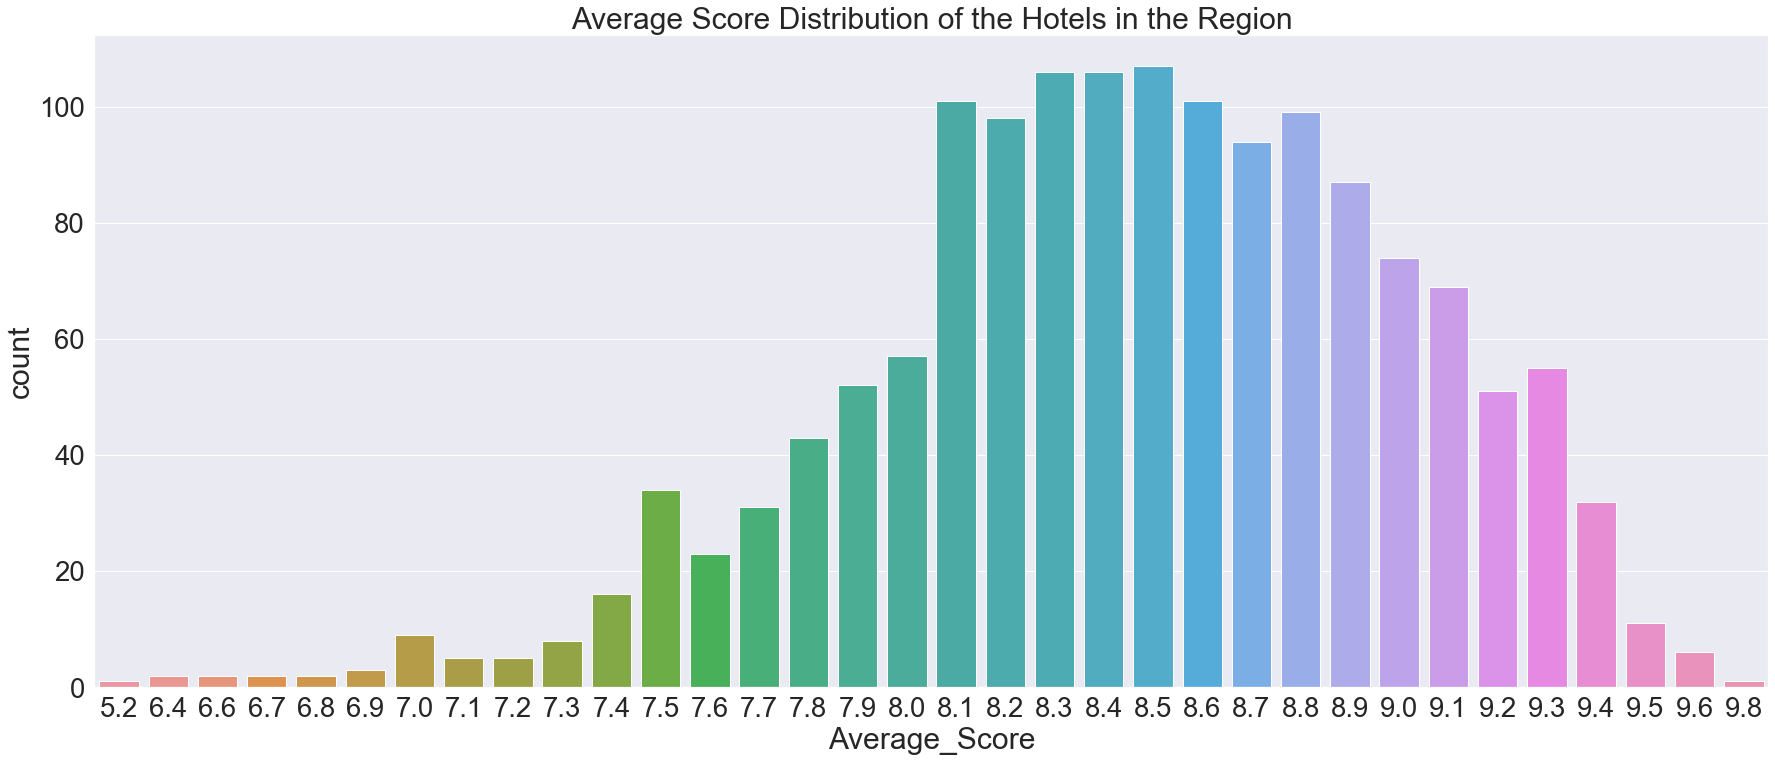

In [21]:
#Plotting the hotels' average score distribution
rcParams['figure.figsize'] = 50 , 18
rcParams['axes.labelsize'] = 14

data_plot = df[['Hotel_Name', 'Average_Score']].drop_duplicates()
sns.set(font_scale = 2.5)
a4_dims = (30, 12)
fig, ax = pyplot.subplots(figsize = a4_dims)
sns.countplot(ax = ax, x = 'Average_Score', data = data_plot)
plt.title('Average Score Distribution of the Hotels in the Region')

In [22]:
#Computing the statistics for the columns
df.describe()

Additional_Number_of_Scoring  Average_Score  \
count                 515212.000000  515212.000000   
mean                     498.416021       8.397767   
std                      500.668595       0.547952   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      342.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515212.000000            515212.000000   
mean                           18.540822              2744.698889   
std                            29.693991              2318.090821   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3633.000000   
max                           408.000000             16670.000000   

       Review_Total_Positive_Word_Counts  \
count                      515212.000000   
mean                           17.778256   
std                            21.804541   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
count                               515212.000000   515212.000000   
mean                                     7.164895        8.395532   
std                                     11.039354        1.637467   
min                                      1.000000        2.500000   
25%                                      1.000000        7.500000   
50%                                      3.000000        8.800000   
75%                                      8.000000        9.600000   
max                                    355.000000       10.000000   

                 lat            lng  
count  515212.000000  515212.000000  
mean       49.432984       2.893972  
std         3.461936       4.669732  
min        41.328376      -0.369758  
25%        48.213810      -0.143372  
50%        51.499981       0.019886  
75%        51.516288       4.841163  
max        52.400181      16.429233

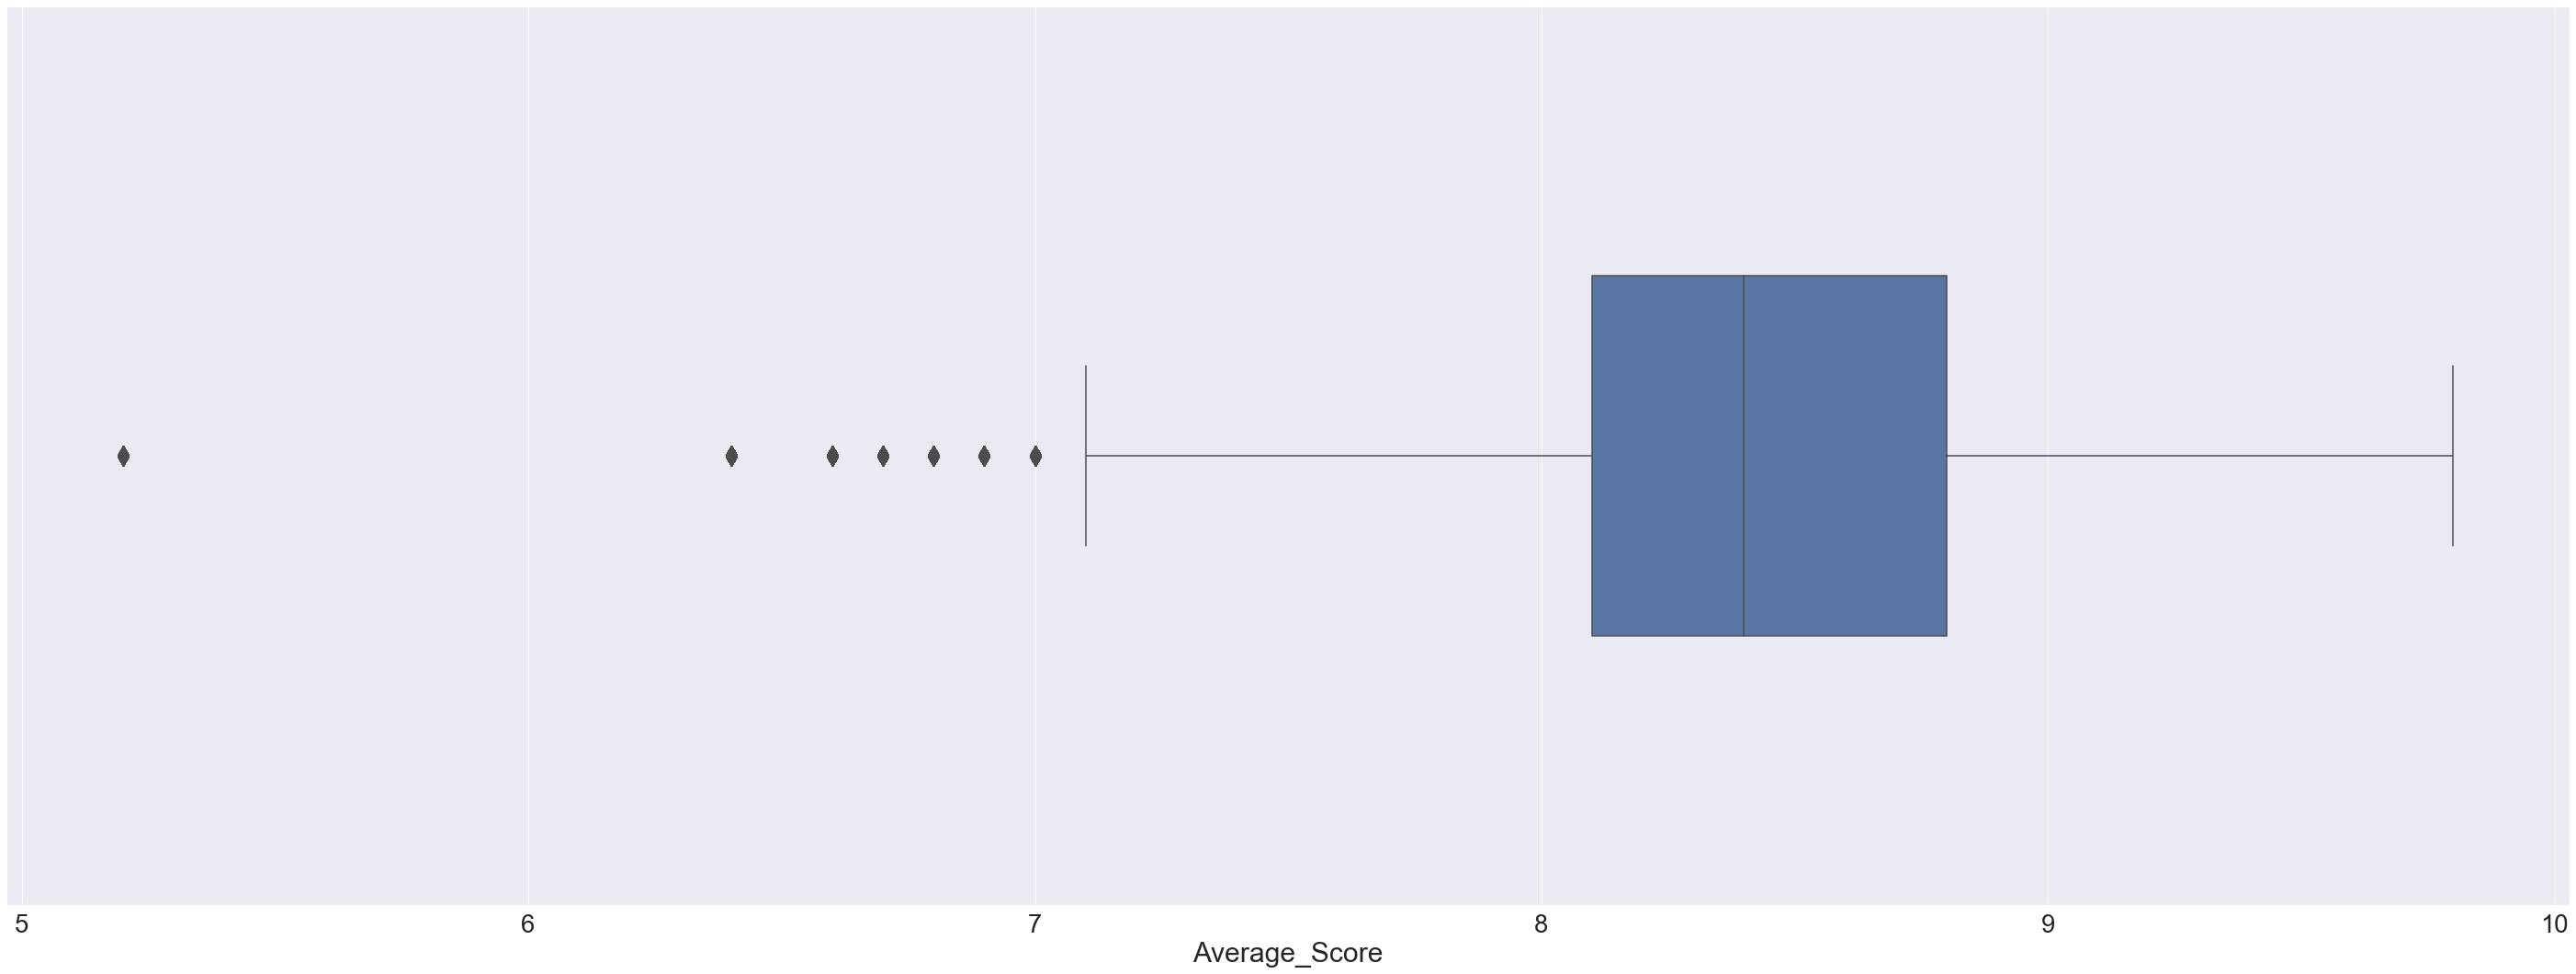

In [23]:
#Boxplot for visualising the outliers in the average score
sns.boxplot(df['Average_Score'],saturation=0.75, width=0.4, fliersize=15)

As can be seen in the Average Score plot and statistics table above, the average score given by the reviews for the hotels are mainly around 8.39 out of 10. There are a very few hotels that are has an average score below 7, and they are the outliers. 

In [24]:
text = ''
for i in range(df.shape[0]):
    text = ''.join([text, df['Reviewer_Nationality'].values[i]])

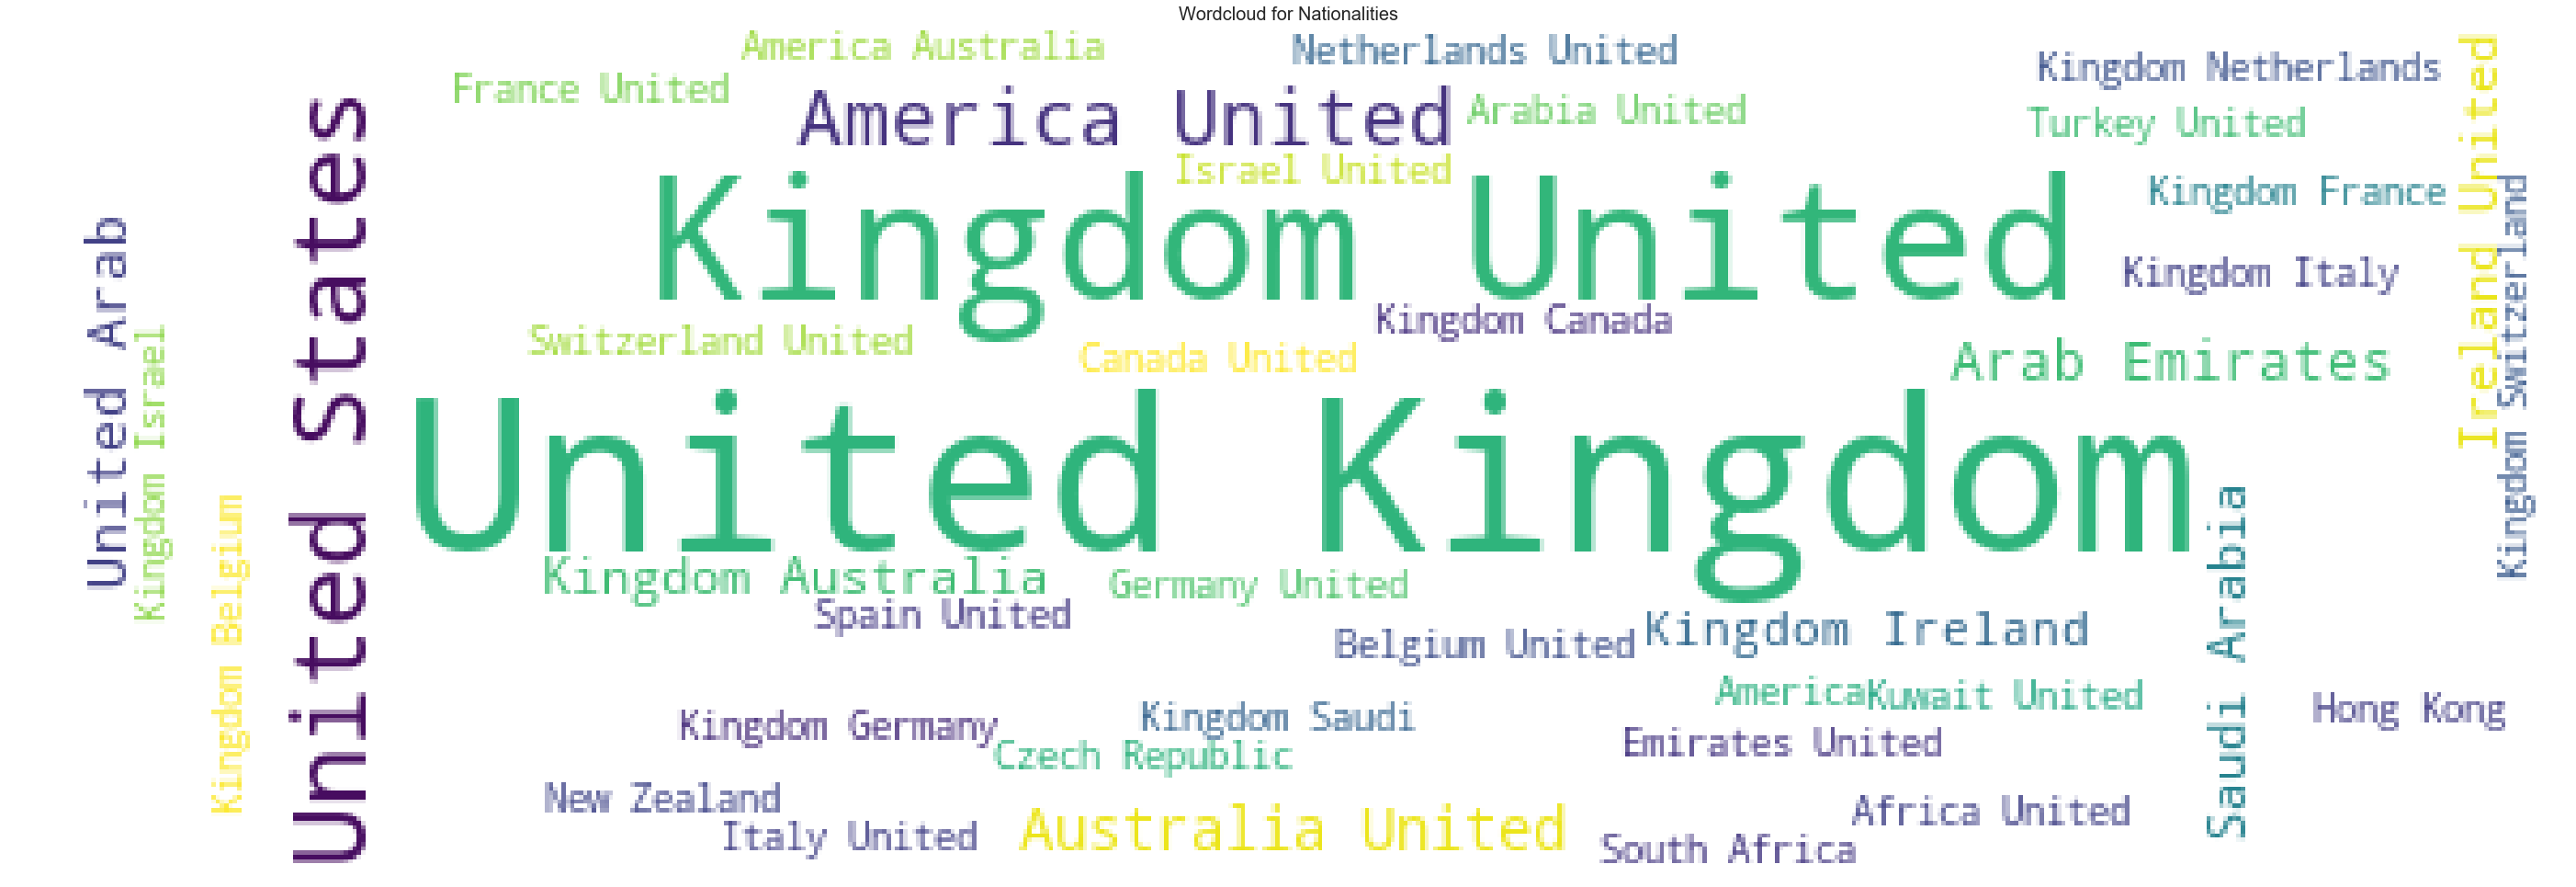

In [25]:
#Plotting the wordcloud for reviewer nationalities
word = WordCloud(background_color = 'white', width = 600, \
                 height = 200, max_font_size = 50, max_words = 40). generate(text)
word.recolor(random_state = 312)

plt.imshow(word)
plt.title('Wordcloud for Nationalities', size=20)
plt.axis('off')
plt.show()

In [26]:
df.Reviewer_Nationality.describe()

count               515212
unique                 227
top        United Kingdom 
freq                245110
Name: Reviewer_Nationality, dtype: object

In [27]:
#Checking the top 10 nationality of the reviewers
df.Reviewer_Nationality.value_counts().head(10)

 United Kingdom               245110
 United States of America      35349
 Australia                     21648
 Ireland                       14814
 United Arab Emirates          10229
 Saudi Arabia                   8940
 Netherlands                    8757
 Switzerland                    8669
 Germany                        7929
 Canada                         7883
Name: Reviewer_Nationality, dtype: int64

As seen in the wordcloud and value counts for the reviewer nationalities above, the nationality of the reviewers are mainly UK, USA, Australia, Ireland, UAE and Saudi Arabia. These are the profiles that mainly living in the UK, especially in London. As we observed the top 20 mentioned hotels, it was seen that majority of them in London, UK.

In [28]:
df.Review_Date.describe()

count       515212
unique         731
top       8/2/2017
freq          2584
Name: Review_Date, dtype: object

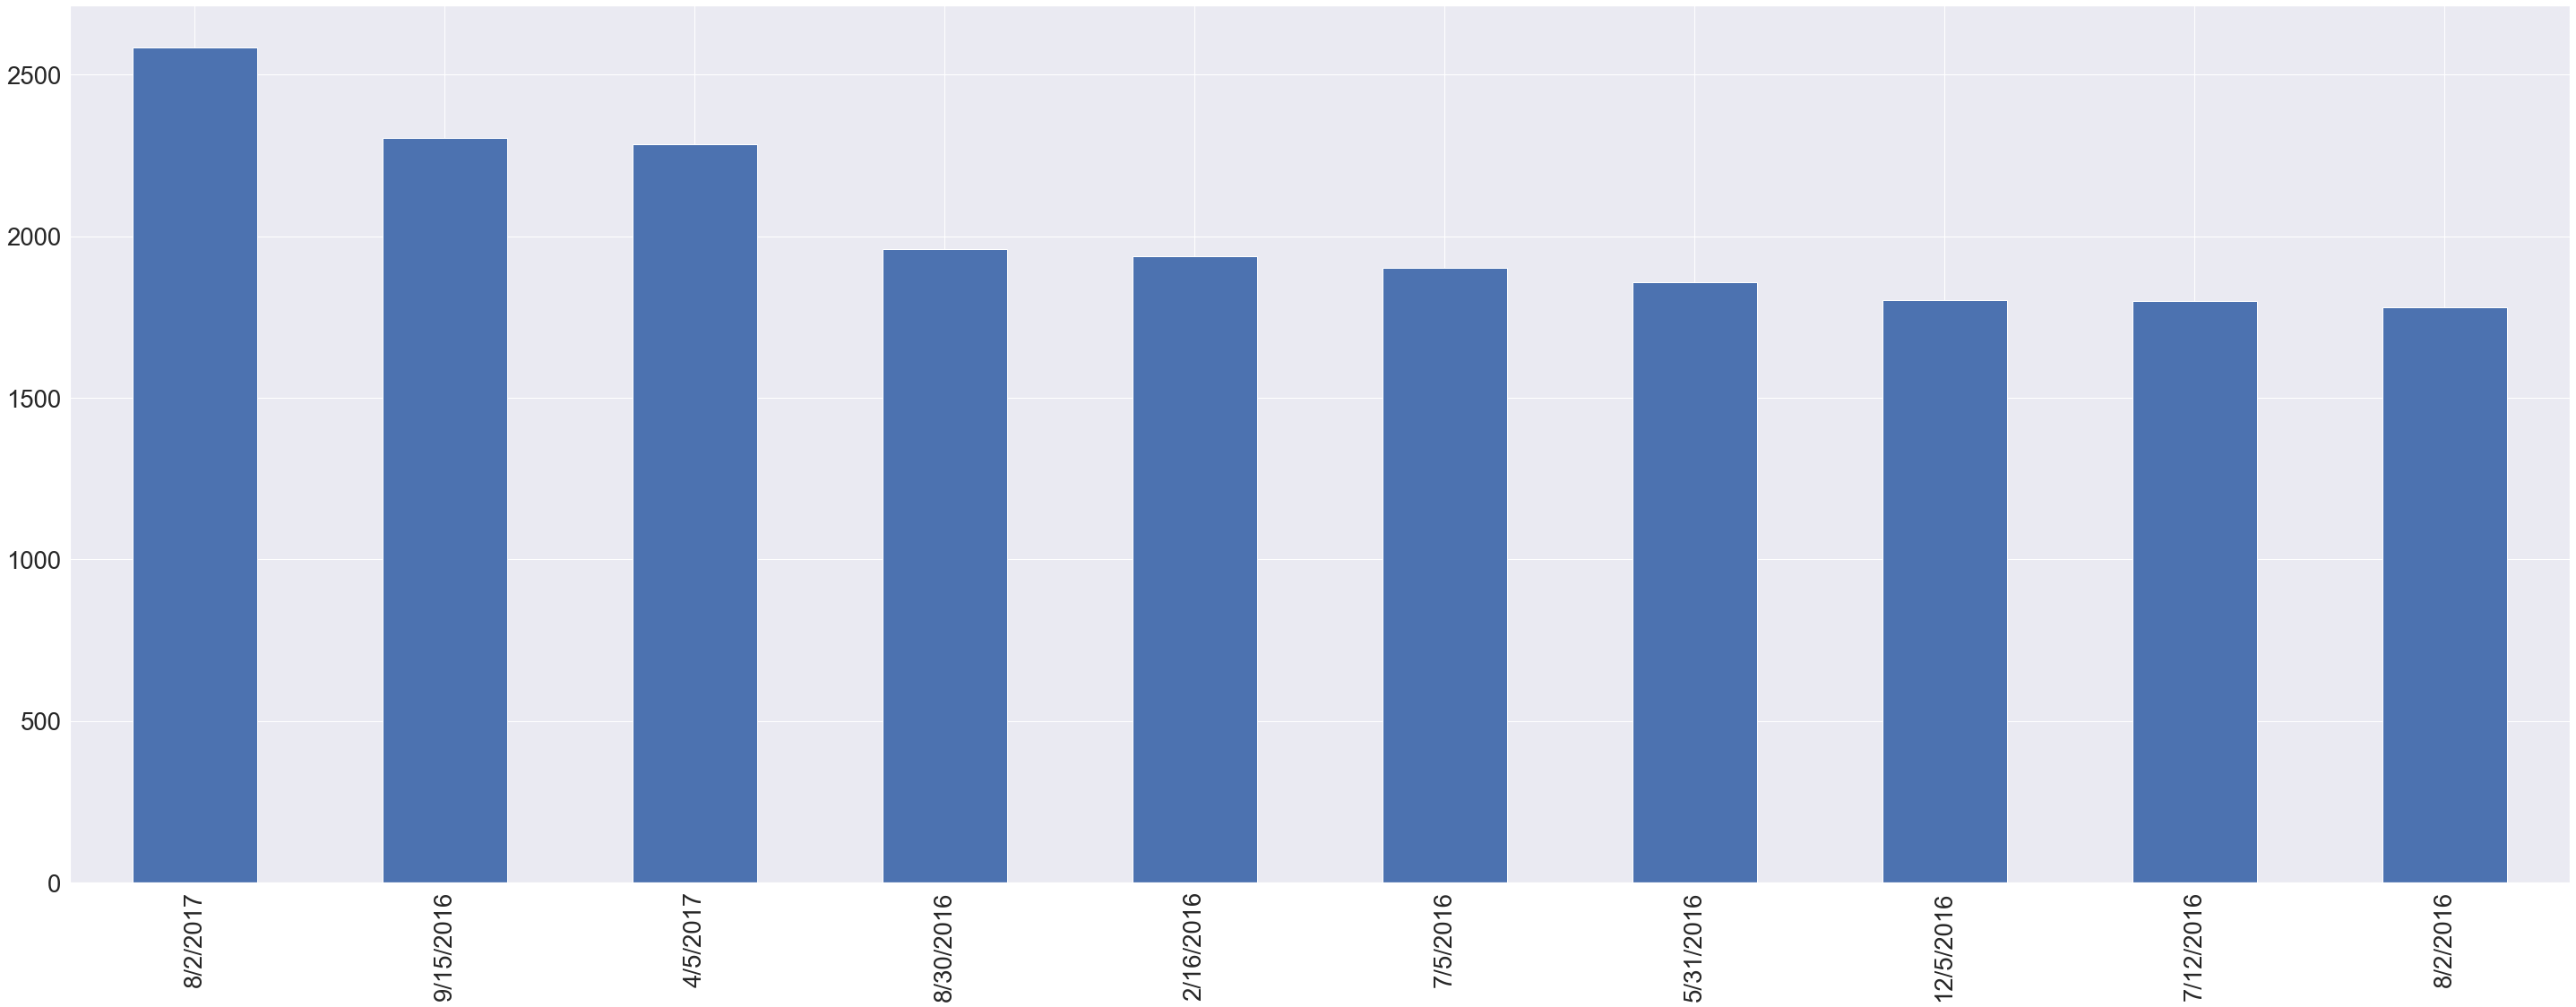

In [29]:
#Checking the dates where highest 10 number of reviews were made
Review_Date_count = df.Review_Date.value_counts()
Review_Date_count[:10].plot(kind = 'bar')

Majority of the reviews were made (80% of the top 10) during spring-summer period, which might be indicative of the times around when the customers stayed at hotels. This might be indicating that customers' purpose of stay might be for holiday rather than for business. We will check the purpose of the stay in the upcoming stages

# 2. Exploratory Data Analysis for TOP 20 Hotels Only

Now we will perform the similar analysis conducted on the global data only on the top 20 hotels. This is done to see if there are any interesting patterns we would see if we were to keep the dataset more specific.

In [30]:
#First let's filter the data set on only the top 20 hotels:

df_top20= df[(df['Hotel_Name']=='Britannia International Hotel Canary Wharf') | (df['Hotel_Name']=='Strand Palace Hotel') | (df['Hotel_Name']=='Park Plaza Westminster Bridge London')|(df['Hotel_Name']=='Copthorne Tara Hotel London Kensington')|(df['Hotel_Name']=='DoubleTree by Hilton Hotel London Tower of London	')|(df['Hotel_Name']=='Grand Royale London Hyde Park')|(df['Hotel_Name']=='Holiday Inn London Kensington')|(df['Hotel_Name']=='Hilton London Metropole')|(df['Hotel_Name']=='Millennium Gloucester Hotel London')|(df['Hotel_Name']=='Intercontinental London The O2')|(df['Hotel_Name']=='Park Grand Paddington Court')|(df['Hotel_Name']=='Hilton London Wembley')|(df['Hotel_Name']=='Park Plaza County Hall London')|(df['Hotel_Name']=='Blakemore Hyde Park	')|(df['Hotel_Name']=='Park Plaza London Riverbank')|(df['Hotel_Name']=='M by Montcalm Shoreditch London Tech City')|(df['Hotel_Name']=='DoubleTree by Hilton London Docklands Riverside')|(df['Hotel_Name']=='St James Court A Taj Hotel London')|(df['Hotel_Name']=='Park Grand London Kensington')|(df['Hotel_Name']=='Hotel Da Vinci')]

(array([0, 1]), <a list of 2 Text xticklabel objects>)

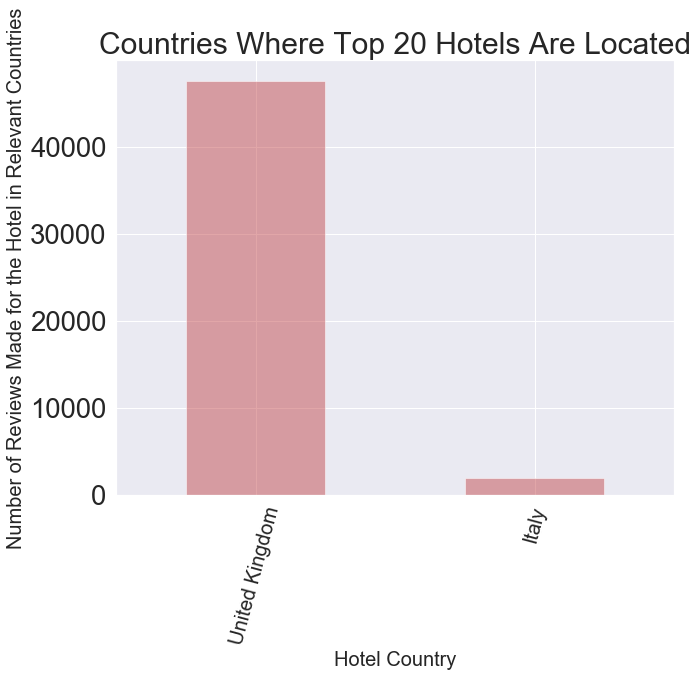

In [31]:
#Checking the countries where the hotels are located
Hotel_Country_count = df_top20.hotel_country.value_counts()
Hotel_Country_count.plot(kind = 'bar', figsize = (10, 8), alpha=0.5, color='r')
plt.xlabel('Hotel Country', size=20)
plt.ylabel('Number of Reviews Made for the Hotel in Relevant Countries', size=20)
plt.title('Countries Where Top 20 Hotels Are Located', size=30)
plt.xticks(size=20, rotation=75)

Interestingly, almost all of the top 20 hotels mentioned in the reviews are in the UK, in London. Let's see which hotel in top 20 is in Italy

In [32]:
df_top20[df_top20['hotel_country']=='Italy']['Hotel_Name'].value_counts()

Hotel Da Vinci    1876
Name: Hotel_Name, dtype: int64

In [33]:
df_top20[df_top20['hotel_country']=='Italy']['Reviewer_Nationality'].value_counts()

 United Kingdom               319
 Switzerland                   97
 Germany                       86
 United States of America      86
 Italy                         74
                             ... 
 Mexico                         1
 Costa Rica                     1
 Venezuela                      1
 Moldova                        1
 Gambia                         1
Name: Reviewer_Nationality, Length: 96, dtype: int64

Hotel Davinci is the only hotel that is located outside the UK, in Italy among the top 20 hotels by popularity.

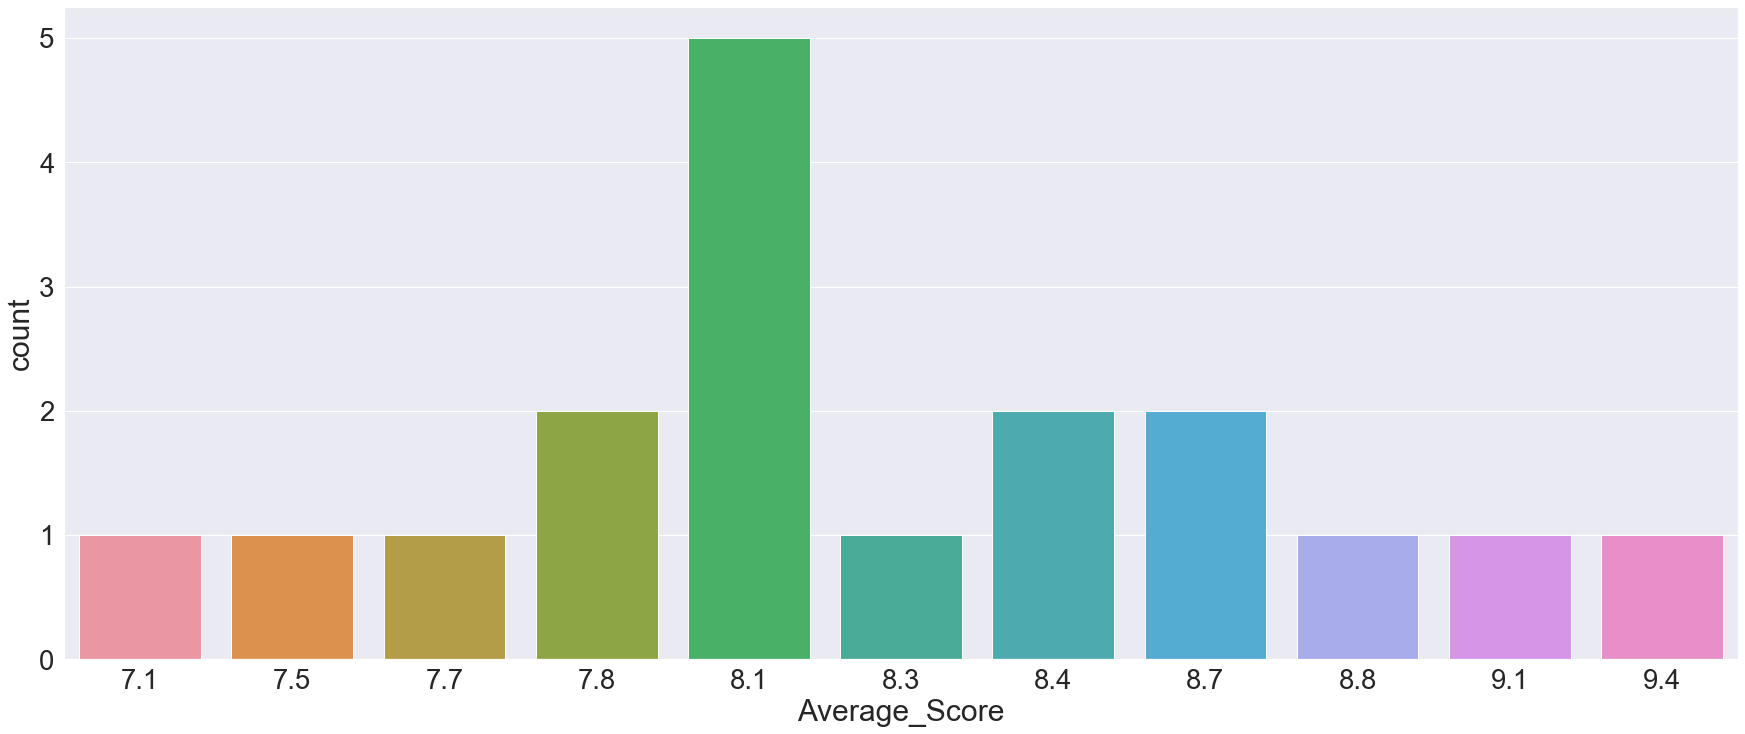

In [34]:
#Plotting the top 20 hotels' average score distribution
rcParams['figure.figsize'] = 50 , 18
rcParams['axes.labelsize'] = 14

data_plot = df_top20[['Hotel_Name', 'Average_Score']].drop_duplicates()
sns.set(font_scale = 2.5)
a4_dims = (30, 12)
fig, ax = pyplot.subplots(figsize = a4_dims)
sns.countplot(ax = ax, x = 'Average_Score', data = data_plot)

In [35]:
d=df_top20.groupby('Hotel_Name')['Average_Score'].value_counts(sort=True, ascending=False)
d

Hotel_Name                                       Average_Score
Britannia International Hotel Canary Wharf       7.1              4789
Copthorne Tara Hotel London Kensington           8.1              3577
DoubleTree by Hilton London Docklands Riverside  8.1              2147
Grand Royale London Hyde Park                    7.7              2958
Hilton London Metropole                          7.5              2628
Hilton London Wembley                            8.8              2227
Holiday Inn London Kensington                    7.8              2768
Hotel Da Vinci                                   8.1              1876
Intercontinental London The O2                   9.4              2551
M by Montcalm Shoreditch London Tech City        9.1              2155
Millennium Gloucester Hotel London               7.8              2565
Park Grand London Kensington                     8.4              2059
Park Grand Paddington Court                      8.1              2288
Park Plaza Cou

In [36]:
df_top20.describe()

Additional_Number_of_Scoring  Average_Score  \
count                  49473.000000   49473.000000   
mean                    1640.743941       8.167566   
std                      584.161152       0.581664   
min                      904.000000       7.100000   
25%                     1243.000000       7.800000   
50%                     1427.000000       8.100000   
75%                     2288.000000       8.700000   
max                     2682.000000       9.400000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                       49473.000000             49473.000000   
mean                           21.540335              7255.101793   
std                            32.465730              2976.901766   
min                             0.000000              3826.000000   
25%                             3.000000              4802.000000   
50%                            11.000000              6539.000000   
75%                            27.000000              9086.000000   
max                           402.000000             16670.000000   

       Review_Total_Positive_Word_Counts  \
count                       49473.000000   
mean                           15.328886   
std                            18.983453   
min                             0.000000   
25%                             5.000000   
50%                            10.000000   
75%                            19.000000   
max                           373.000000   

       Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
count                                49473.000000    49473.000000   
mean                                     5.551998        8.103938   
std                                      8.895956        1.789821   
min                                      1.000000        2.500000   
25%                                      1.000000        7.100000   
50%                                      2.000000        8.300000   
75%                                      6.000000        9.600000   
max                                    181.000000       10.000000   

                lat           lng  
count  49473.000000  49473.000000  
mean      51.280374      0.220234  
std        1.141096      1.778368  
min       45.533137     -0.283526  
25%       51.499046     -0.186342  
50%       51.501910     -0.121419  
75%       51.511099     -0.088947  
max       51.557696      9.171102

As can be seen above the average score of the top 20 hotels are in the range of 7.1 - 9.4. Which indicates that some of them, (e.g. Britannia International Hotel Canary Wharf) are given an average rating well below the mean average score of all the hotel, 8.3 despite their popularity. So this indicates that popularity, or frequency of how much a specific hotel is being reviewed is not essentially correlated with how good it's average score is.

In [37]:
#Checking the Nationality of the reviewers for the top 20 hotels
df_top20.Reviewer_Nationality.value_counts().head(10)

 United Kingdom               33102
 United States of America      1954
 Ireland                       1516
 Australia                     1515
 United Arab Emirates           636
 Saudi Arabia                   560
 Switzerland                    520
 Canada                         496
 Netherlands                    440
 Germany                        419
Name: Reviewer_Nationality, dtype: int64

# 3. Data Cleaning and Transformation for Reviews

In [38]:
#Exploring the Reviews where no positive comments are made but negative
a = df.loc[df.Review_Total_Positive_Word_Counts == 0]
print('Completely negative reviews:' , len(a))
b = a[['Positive_Review', 'Negative_Review']]
b.head(10)

Completely negative reviews: 35904


Positive_Review                                    Negative_Review
8       No Positive   Even though the pictures show very clean room...
32      No Positive   Our bathroom had an urine order Shower was ve...
98      No Positive   Got charged 50 for a birthday package when it...
121     No Positive   The first room had steep steps to a loft bed ...
134     No Positive   Foyer was a mess Only place to relax was the ...
146     No Positive   We booked a 3 night stay in a suite On arriva...
169     No Positive   Nothing One Of The Receptionist she did a rac...
172     No Positive   Hotel under sonstruction which we weren t awa...
202     No Positive   Renovation around the hotel sometimes can sta...
209     No Positive   Not given the room type we had booked and pre...

In [39]:
#neg_words = df.Review_Total_Negative_Word_Counts.value_counts()
#neg_words[:10]

In [40]:
#Exploring the Reviews where no negative comments are made but positve
a = df.loc[df.Review_Total_Negative_Word_Counts == 0]
print('Not completely positive reviews:' , len(a))
b = a[['Positive_Review', 'Negative_Review']]
b.head(10)

Not completely positive reviews: 127757


Positive_Review Negative_Review
1    No real complaints the hotel was great great ...     No Negative
13   This hotel is being renovated with great care...     No Negative
15   This hotel is awesome I took it sincirely bec...     No Negative
18   Public areas are lovely and the room was nice...     No Negative
48   The quality of the hotel was brilliant and ev...     No Negative
53   Beautiful setting in a lovely park room very ...     No Negative
55   The hotel is lovely and the staff were amazin...     No Negative
59   Basically everything The style of the hotel i...     No Negative
75   The whole hotel was very clean the staff were...     No Negative
78   Hotel was really nice staff were very friendl...     No Negative

In [112]:
#Merging the negative and positive reviews
#Labelling the reviews that are lower than 8 as 'is_bad'
df['review'] = df['Negative_Review'] + df['Positive_Review']
df['is_bad'] = df['Reviewer_Score'].apply(lambda x: 1 if x < 8 else 0)

#Replicating an array for top 20 hotels as well:
df_top20['review'] = df_top20['Negative_Review'] + df_top20['Positive_Review']
df_top20['is_bad'] = df_top20['Reviewer_Score'].apply(lambda x: 1 if x < 8.16 else 0)



E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
#Checking if the labels have been formed:

reviews_df = df[['review', 'is_bad']]
reviews_df.head()

reviews_df_top20 = df_top20[['review', 'is_bad']]
reviews_df_top20.head()

review  is_bad
5257   Extra bed was the worst breakfast queue was r...       1
5258  No Negative Around the corner from the London ...       1
5259   I wish you had wheat free snacks You re alway...       0
5260   Bit of a wait for a table at breakfast  The s...       0
5261   Housekeeping would bang on your door to wake ...       1

In the line below, we will be randomly sampling 10% of the reviews. Due to  analyzing all of the reviews are taking longer times and causing memory issues. To make it computationally easier, we only analyze the 10% of the review. This is the most amount of data we could process without getting a memory error or Juptyter crashing. And we acknowledge that this might cause some important information loss.

In [115]:
#Randomly sampling 10% of the reviews
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state = 42)

#Randomly sampling 50% of the reviews for top20
reviews_df_top20 = reviews_df_top20.sample(frac = 0.1, replace = False, random_state = 42)

In [116]:
#Here we will replace the 'No Negative' and 'No Positive' entries as we don't want them to appear in our word clous that we will be forming in the upcoming stages.
#This will leave us with a review column formed of either completely positive or completely negative reviews:
reviews_df['review'] = reviews_df['review'].apply(lambda x: x.replace('No Negative', '').replace('No Positive', ''))

reviews_df_top20['review'] = reviews_df_top20['review'].apply(lambda x: x.replace('No Negative', '').replace('No Positive', ''))

In the next piece of code, we will start forming the grounds for the NLP analysis we will be conducting in the later stages. 

1.First, we create a function that will take in the words from a given input and label them as adjectives, verbs, nouns or adverbs using 'pos_tag' and 'wordnet' which are found NLTK library. This will help labelling the words and to find the meaning of words.
*Please note that the code below were inspired from different studies that were conducted in stakoverflow [1] and stackoverrun [2]; and from nltk.org:
*[1]:https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
*[2]:https://stackoverrun.com/tr/q/4229916
        
2.Secondly, we are creating a function, clean_text, that will prepare our text within the reviews by removing punctuations, lowering the capital words, removing the stop words etc.
-Apart from these steps, by using the WordNetLemmatizer and lemmatize 
-Lemmatization helps Lemmatization grouping together the different inflected forms of a word so they can be analysed as a single item. So it links words with similar meaning to one word.
*[3]:https://stackoverflow.com/questions/61982023/using-wordnetlemmatizer-lemmatize-with-pos-tags-throws-keyerror
*[4]:https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

In [117]:
# labelling text

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
# cleannig text

def clean_text(text):
    text = text.lower() # lower text
    text = [word.strip(string.punctuation) for word in text.split(' ')] # remove puncutation
    text = [word for word in text if not any(c.isdigit() for c in word)] # removing numbers
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop] # remove stopwords
    text = [x for x in text if len(x) > 0] # remove empty tokens
    pos_tags = pos_tag(text) # pos_tag given text
    text =[WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags] # lemmatize text
    text = [x for x in text if len(x) > 1] # only one letter removing 
    text = ' '.join(text) # join all
    return(text)

In [118]:
#Now, using the functions we created above, we will clean and tag the reviews in our dataset:
reviews_df['review_cleaned'] = reviews_df['review'].apply(lambda x: clean_text(x))



In [119]:
reviews_df_top20['review_cleaned'] = reviews_df_top20['review'].apply(lambda x: clean_text(x))

In [120]:
reviews_df.head()

review  is_bad  \
425257   Close to Las Ramblas but a bit of a seedy are...       0   
507589                            Clean and good location       0   
219228   Fantastic hotel in the heart of Shoreditch a ...       0   
205533   Not clean Smelly rooms Cigarette Smoke Towels...       1   
216690   Nothing  I liked everything thats why keep co...       0   

                                           review_cleaned  
425257  close las ramblas bite seedy area night modern...  
507589                                clean good location  
219228  fantastic hotel heart shoreditch stone throw d...  
205533  clean smelly room cigarette smoke towel change...  
216690            nothing like everything thats keep come

In [121]:
reviews_df['is_bad'].value_counts()

0    3408
1    1744
Name: is_bad, dtype: int64

In [122]:
reviews_df_top20['is_bad'].value_counts()

0    1434
1    1040
Name: is_bad, dtype: int64

# **Feature Engineering & Customer Profile Analysis**

In [123]:
#We will create a Trip Type column by extracting the purpose of travel from the Tags column:

df['Leisure'] = df['Tags'].map(lambda x: 1 if 'Leisure Trip' in x else 0)
df['Business'] = df['Tags'].map(lambda x: 2 if ' Business trip ' in x else 0)
df['Trip_type'] = df['Leisure'] + df['Business']

 In the next step we are filling in the missing entries for travel purposes. 80% of the travel purposes in the dataset are formed of leisure. As we don't want to disrupt this proportion, we take the empy trip types, randomly select them and assign business prupose for 20% of the randomly selected one, and assign leisure for the remaining 80%

In [124]:
#Filling in the missing entries for travel purposes.
df['Trip_type'] = df[df['Trip_type'] == 0]['Trip_type'].map(lambda x: 1 if random.random() > 0.2 else 2)
df['Trip_type'] = df['Trip_type'].fillna(0)
df['Trip_type'] = df['Trip_type'] + df['Business'] + df['Leisure']
del df['Leisure'] , df['Business']

In [125]:
df['Trip_type'].value_counts()

1.0    345499
2.0    169713
Name: Trip_type, dtype: int64

Text(0.5, 1.0, 'Count of Trip Types in the Reviews')

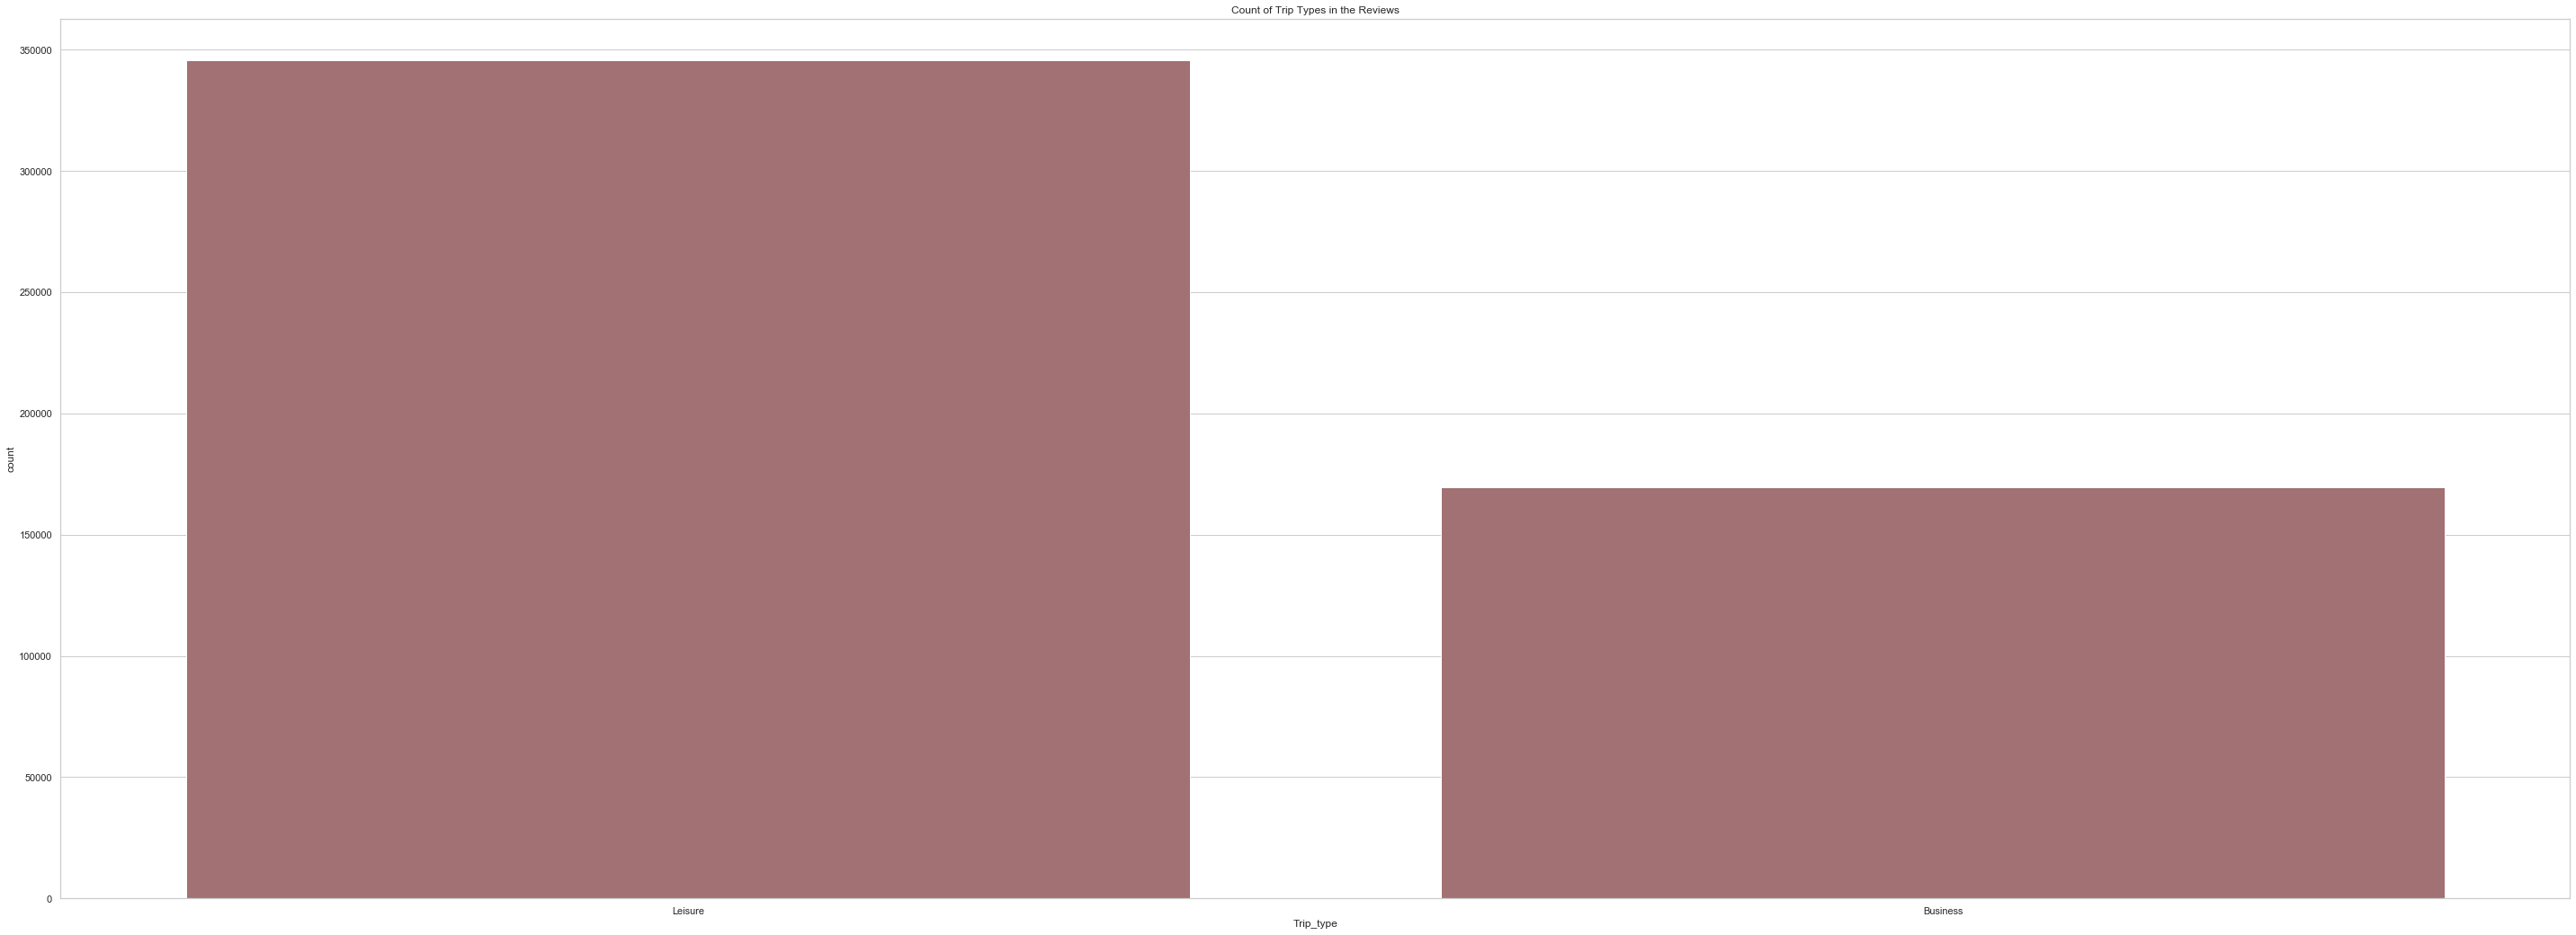

In [126]:
g = sns.countplot(df['Trip_type'], saturation = 0.4, color='r')
x = ['Leisure', 'Business']
g.set_xticklabels(x)
g.set_title('Count of Trip Types in the Reviews')


As seen above, customers who have left reviews have mainly traveled for holiday, which is almost twice as much as the business purpose travels.

Text(0.5, 1.0, 'Trip Type')

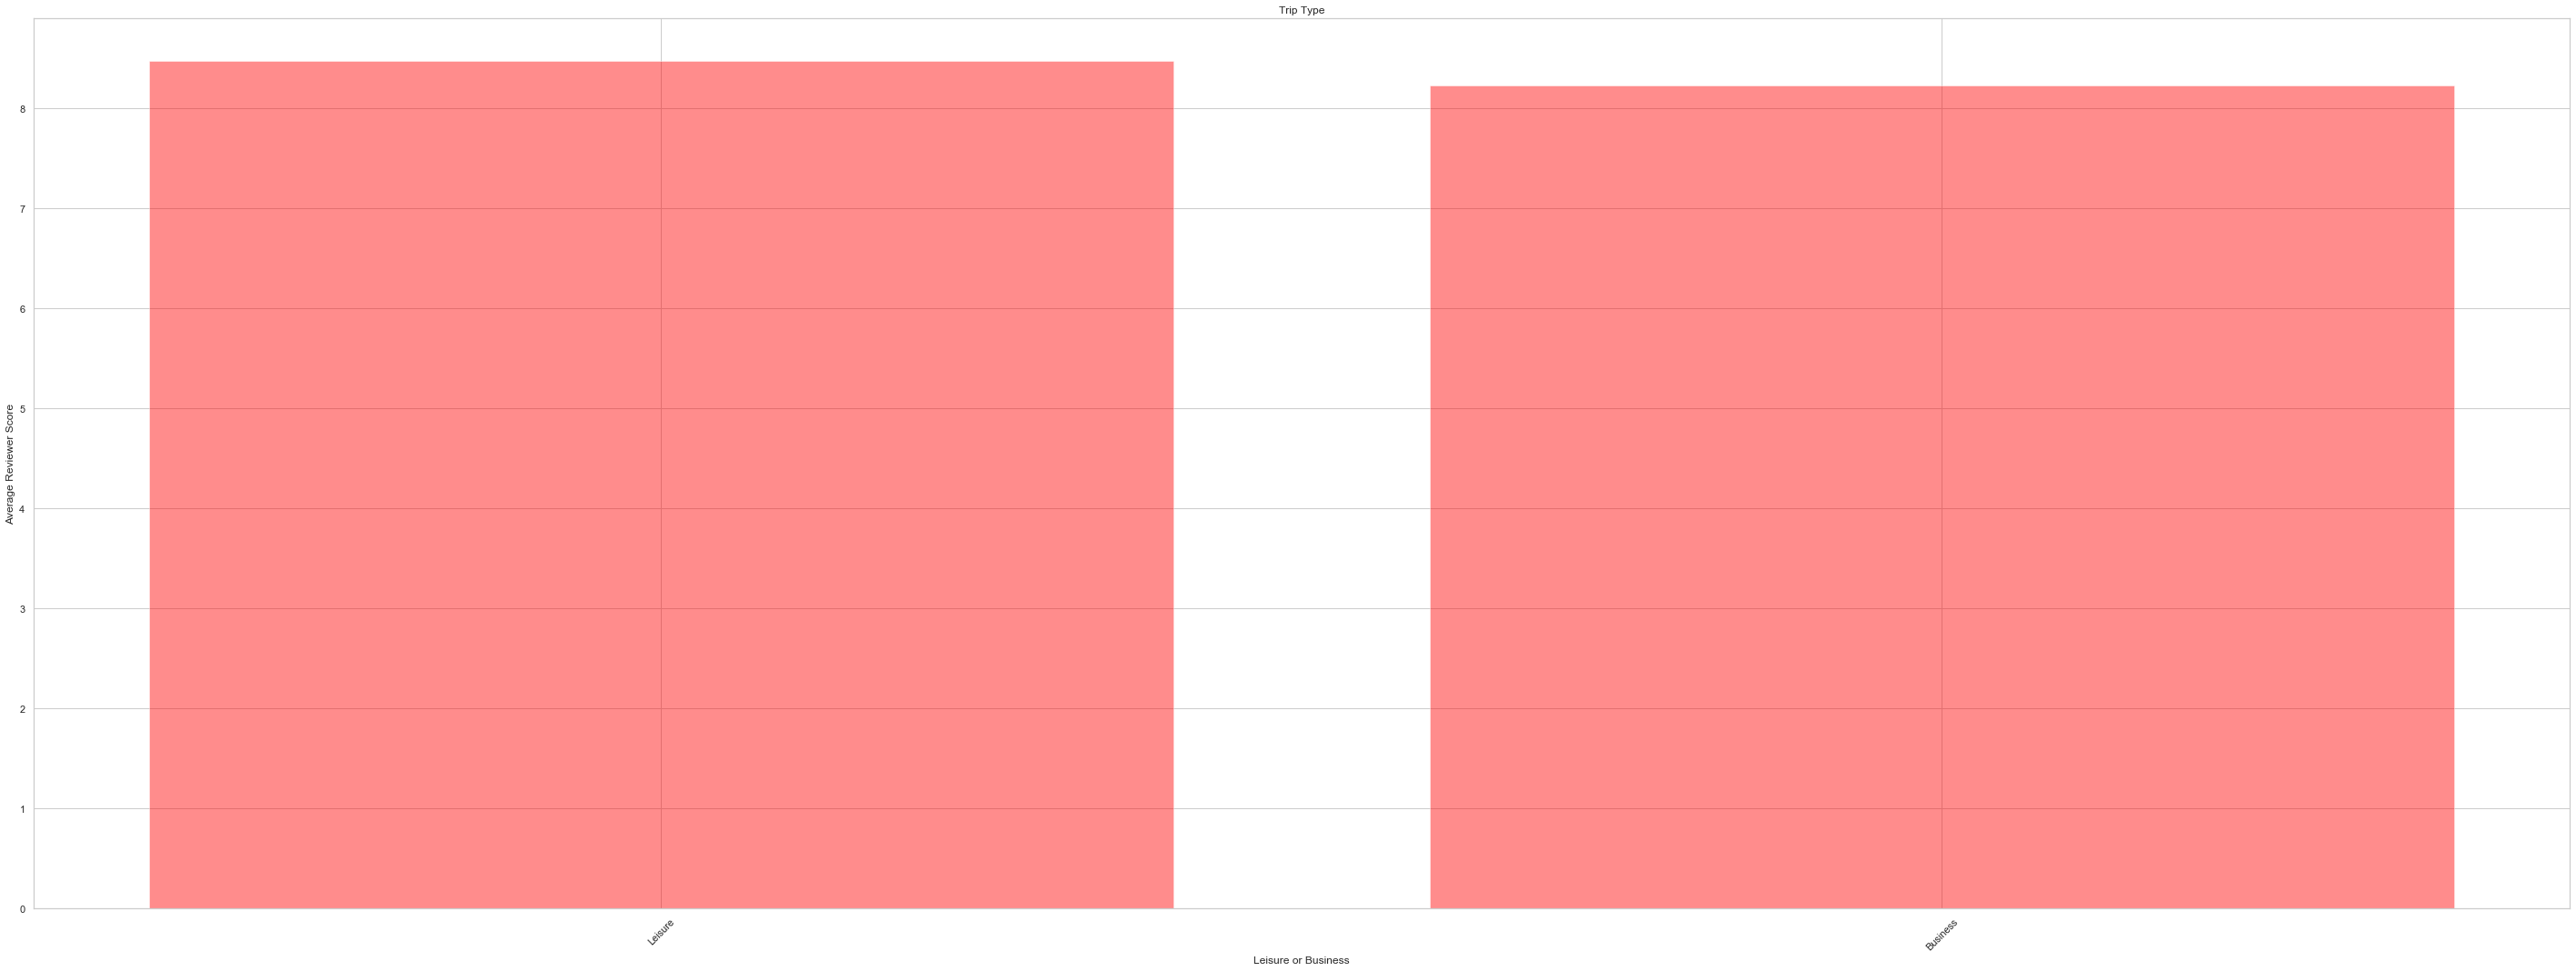

In [127]:
# Trip type
tt_avg = df.groupby('Trip_type')['Reviewer_Score'].mean()
Index = [1,2]
plt.bar(Index,tt_avg,color='red', alpha=0.45)
plt.xticks(Index,['Leisure','Business'],rotation = 45)
plt.ylabel('Average Reviewer Score')
plt.xlabel('Leisure or Business')
plt.title('Trip Type')

There is not much difference in reviewer scores given by the reviewers who were doing a holiday and who were staying for business purposes.

In [128]:
#Couple or Solo or Group or Family_with_older children or Family with younger Children
df['Solo'] = df['Tags'].map(lambda x: 1 if ' Solo traveler ' in x else 0)
df['Couple'] = df['Tags'].map(lambda x: 2 if ' Couple ' in x else 0)
df['Group'] = df['Tags'].map(lambda x: 3 if ' Group ' in x else 0)
df['Family_with_young_children'] = df['Tags'].map(lambda x: 4 if ' Family with young children ' in x else 0)
df['Family_with_older_children'] = df['Tags'].map(lambda x: 5 if ' Family with older children ' in x else 0)
df['whom'] = df['Solo'] + df['Couple'] + df['Group'] + df['Family_with_young_children'] + df['Family_with_older_children']
del df['Solo'], df['Couple'],df['Group'], df['Family_with_young_children'],df['Family_with_older_children']

In [129]:
df.whom.value_counts()

2    252005
1    108431
3     65338
4     60975
5     26320
0      2143
Name: whom, dtype: int64

In [130]:
df['whom'] = df['whom'].map(lambda x: 2 if x == 0 else x)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

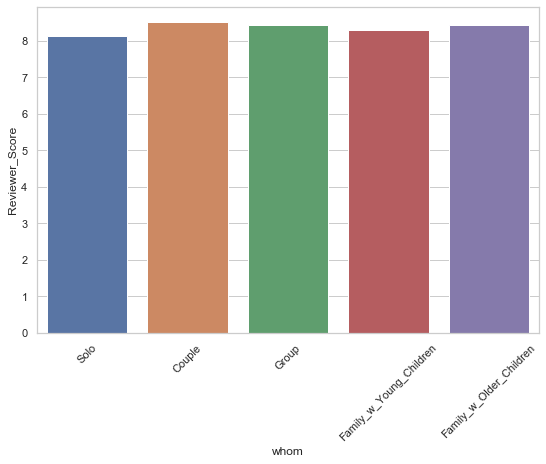

In [131]:
#Whom
whom_hist=df.groupby("whom")['Reviewer_Score'].mean().reset_index().sort_values(by='whom',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
f=sns.barplot(x='whom',y='Reviewer_Score', data=whom_hist)
who = ['Solo', 'Couple', 'Group', 'Family_w_Young_Children', 'Family_w_Older_Children']
f.set_xticklabels(who)
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Familty Profile of the Visitors Staying at the Hotels in the Region')

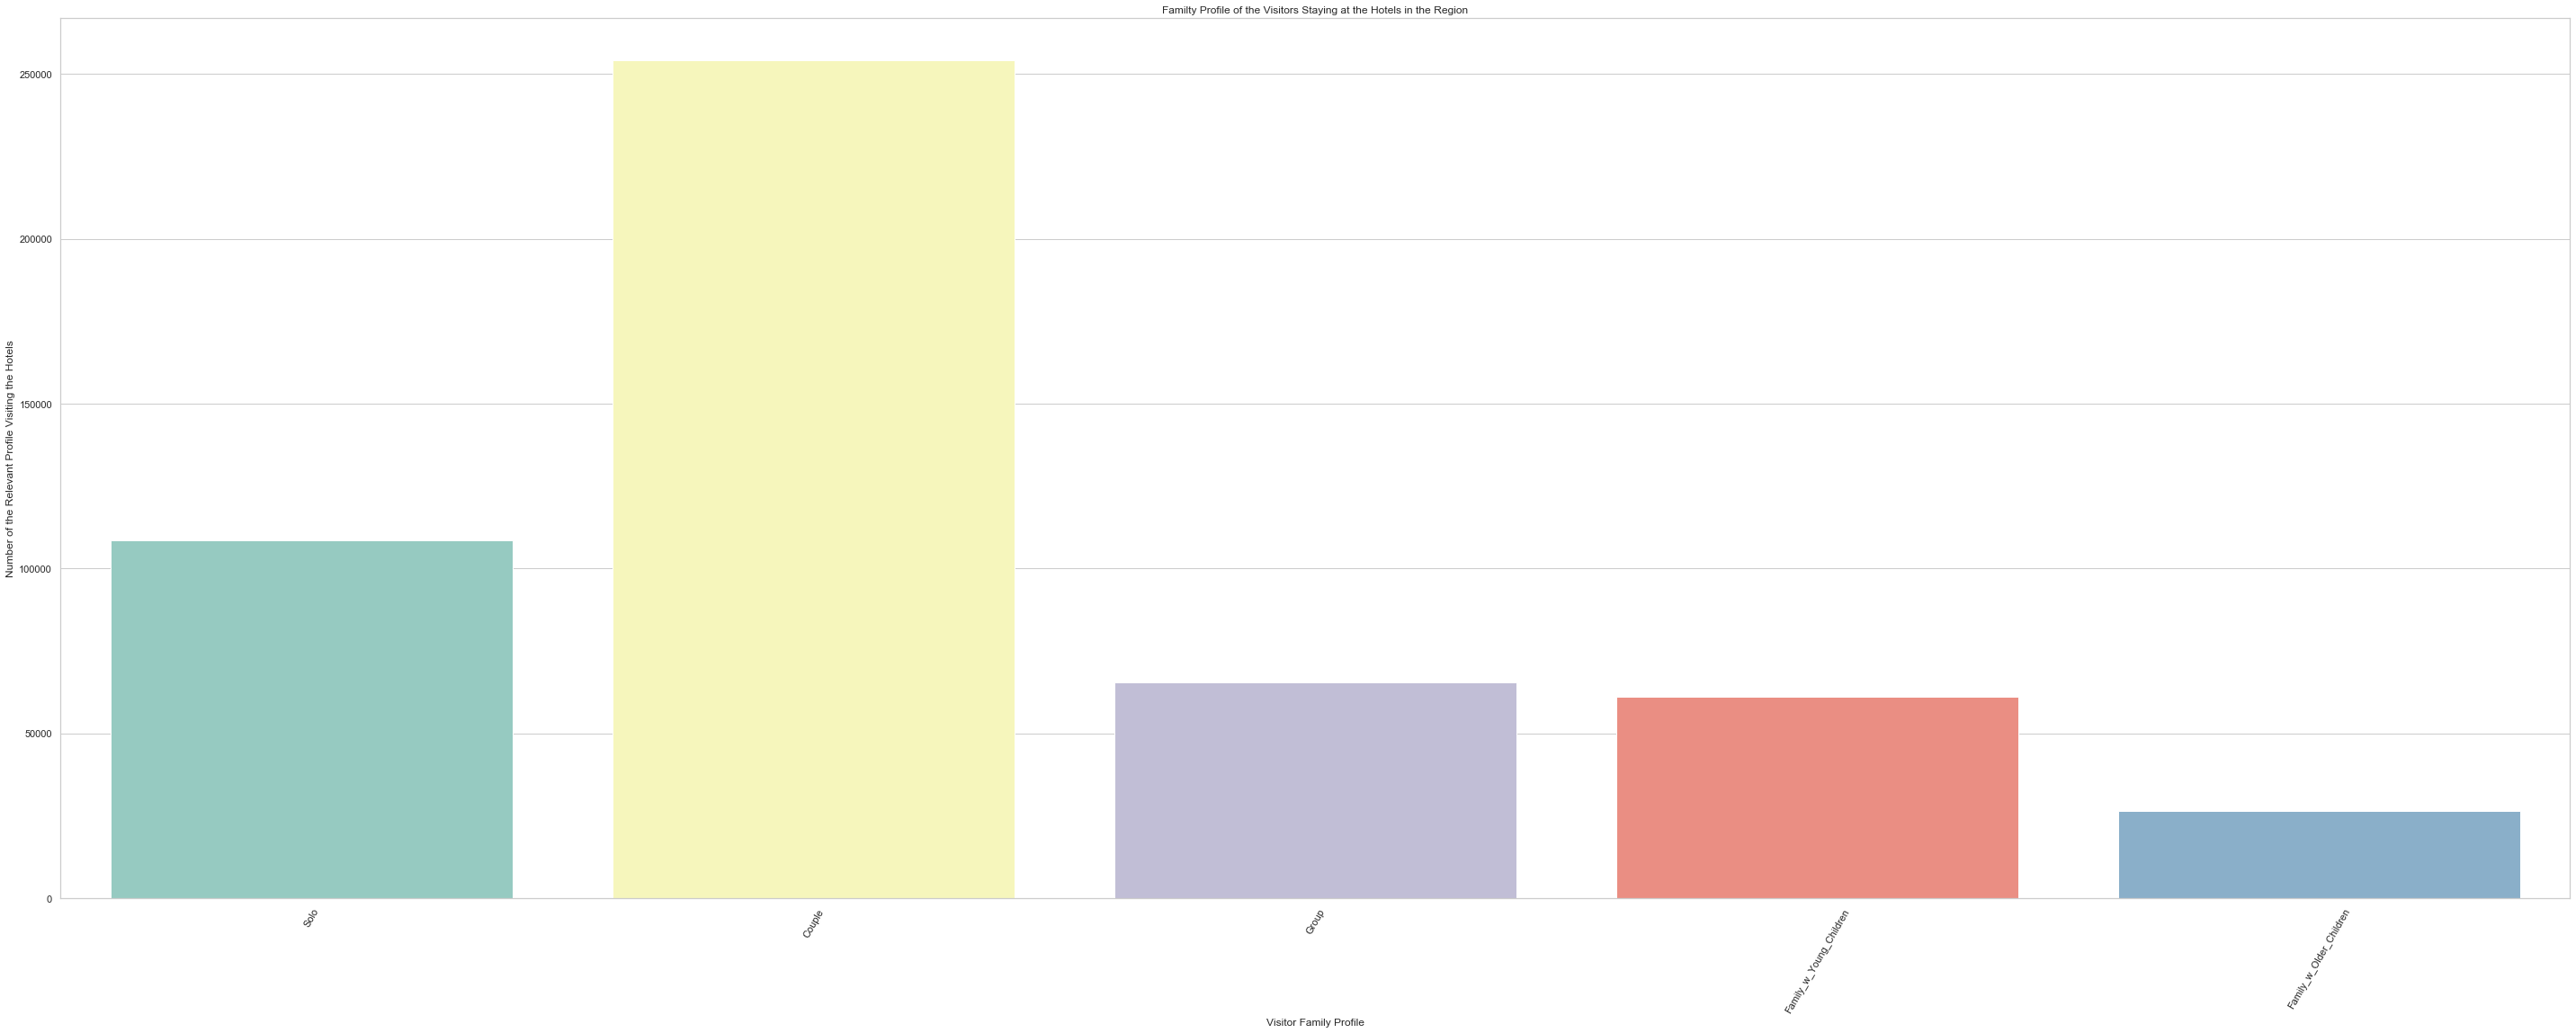

In [132]:
#Whom
ff=sns.countplot(df['whom'], palette='Set3')
who = ['Solo', 'Couple', 'Group', 'Family_w_Young_Children', 'Family_w_Older_Children']
ff.set_xticklabels(who)
plt.xticks(rotation=60)
plt.xlabel('Visitor Family Profile')
plt.ylabel('Number of the Relevant Profile Visiting the Hotels')
plt.title('Familty Profile of the Visitors Staying at the Hotels in the Region')

As could be seen in the countplot above, a very high majority of the travelers were couples, followed by solo and group travellers and families with young children. A few of them were families with older children.

In [133]:
#Extracting the year and month from review date information:
year = df['Review_Date'].map(lambda x: x.split('/')[2])
month = df['Review_Date'].map(lambda x: x.split('/')[0])
df['month'] = month
df['year'] = year

Text(0.5, 1.0, 'Mean Reviewer Scores Through Years')

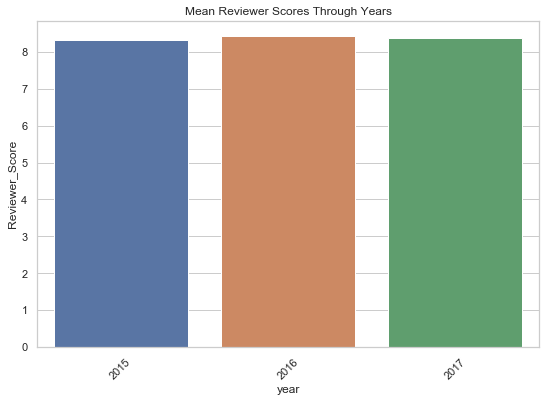

In [134]:
#Checking if there is an of mean reviewer scores throughout the years:
year_hist=df.groupby("year")['Reviewer_Score'].mean().reset_index().sort_values(by='year',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
sns.barplot(x='year',y='Reviewer_Score', data=year_hist)
plt.xticks(rotation=45)
plt.title('Mean Reviewer Scores Through Years')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

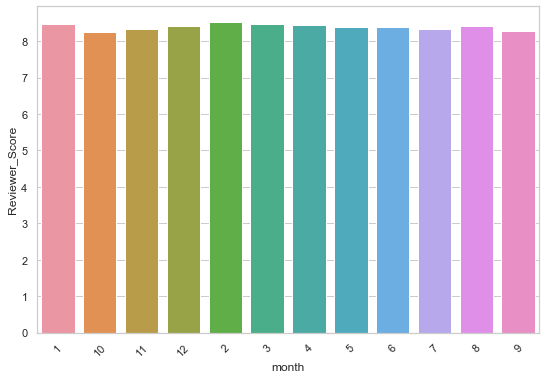

In [135]:
#Checking if there is an of mean reviewer scores throughout the months:
month_hist=df.groupby("month")['Reviewer_Score'].mean().reset_index().sort_values(by='month',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
sns.barplot(x='month',y='Reviewer_Score', data=month_hist)
plt.xticks(rotation=45)

There is not much change observed in mean reviewer scores throughout the years an months as seen in the two plots above.

In [136]:
country = df['Hotel_Address'].map(lambda x: x.split()[-1])
country = country.map(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df['hotel_country'] = country

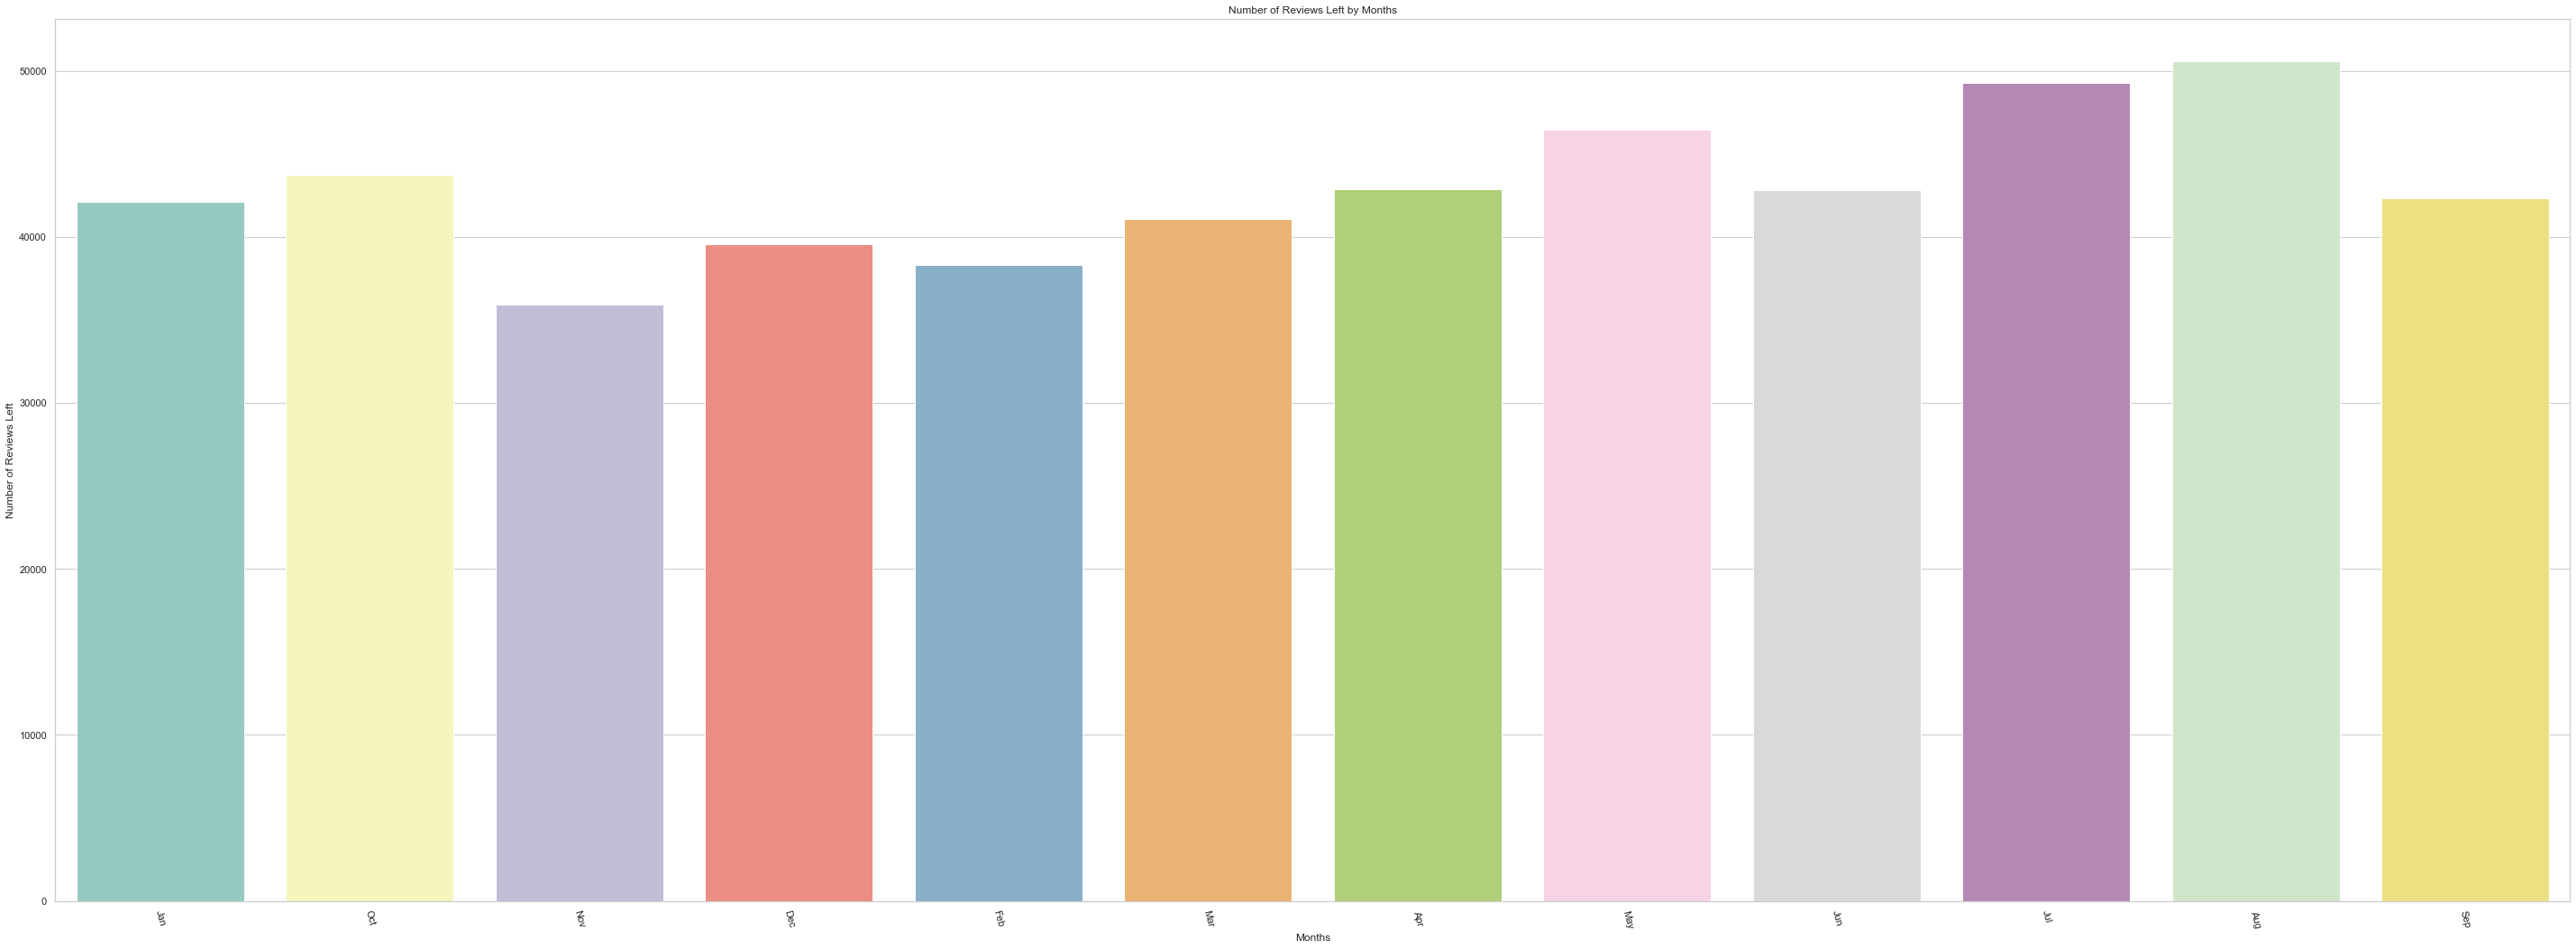

In [137]:
sns.set(style='whitegrid')
Months = ['Jan', 'Oct', 'Nov', 'Dec', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', ]
ff=sns.countplot(df['month'], data=df, palette = 'Set3')
ff.set_xticklabels(Months)
plt.xlabel('Months')
plt.ylabel('Number of Reviews Left')
plt.title('Number of Reviews Left by Months')
plt.xticks(rotation=-75)
plt.show()

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

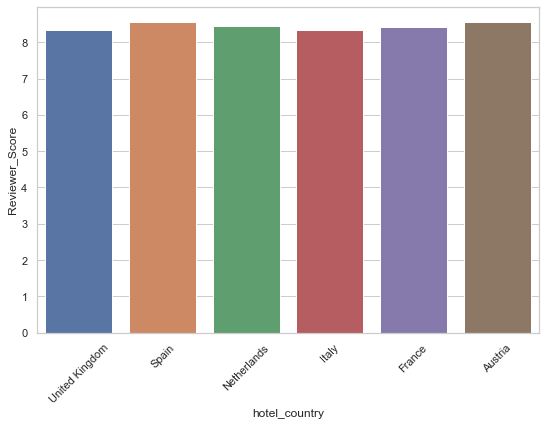

In [138]:
the_hotels_of_countries_hist=df.groupby("hotel_country")['Reviewer_Score'].mean().reset_index().sort_values(by='hotel_country',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
sns.barplot(x='hotel_country',y='Reviewer_Score', data=the_hotels_of_countries_hist)
plt.xticks(rotation=45)

# Feature Engineering & Customer Profile Analysis for TOP 20 Hotels Only

In [140]:
#We will create a Trip Type column for top 20 hotels by extracting the purpose of travel from the Tags column:

df_top20['Leisure'] = df_top20['Tags'].map(lambda x: 1 if 'Leisure Trip' in x else 0)
df_top20['Business'] = df_top20['Tags'].map(lambda x: 2 if ' Business trip ' in x else 0)
df_top20['Trip_type'] = df_top20['Leisure'] + df_top20['Business']

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [141]:
#Filling in the missing entries for travel purposes.
df_top20['Trip_type'] = df_top20[df_top20['Trip_type'] == 0]['Trip_type'].map(lambda x: 1 if random.random() > 0.2 else 2)
df_top20['Trip_type'] = df_top20['Trip_type'].fillna(0)
df_top20['Trip_type'] = df_top20['Trip_type'] + df_top20['Business'] + df_top20['Leisure']
del df_top20['Leisure'] , df_top20['Business']

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Text(0.5, 1.0, 'Count of Trip Types in the Reviews for Top 20 Hotels')

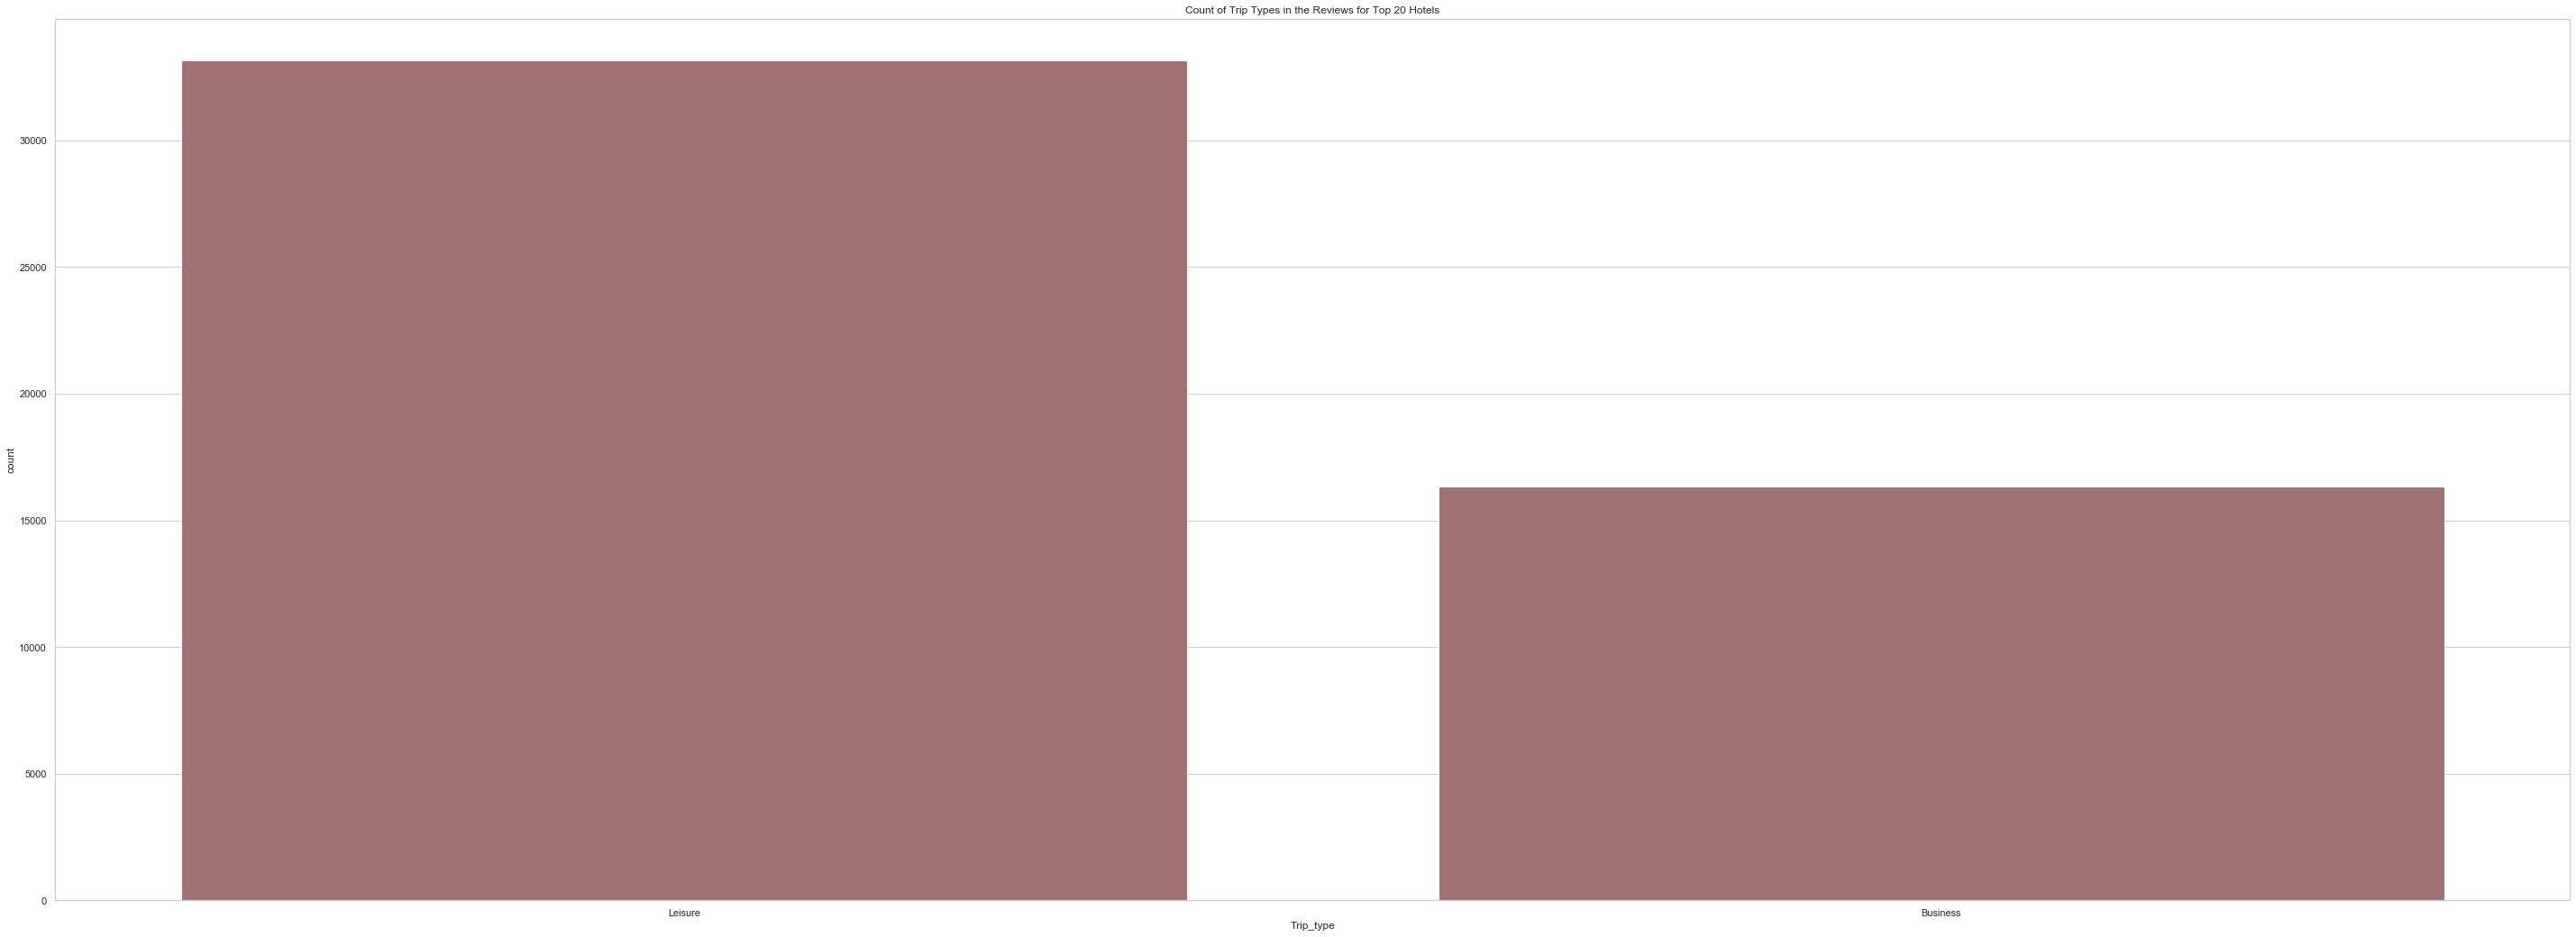

In [142]:
g = sns.countplot(df_top20['Trip_type'], saturation = 0.4, color='r')
x = ['Leisure', 'Business']
g.set_xticklabels(x)
g.set_title('Count of Trip Types in the Reviews for Top 20 Hotels')

In [143]:
#Couple or Solo or Group or Family_with_older children or Family with younger Children
df_top20['Solo'] = df_top20['Tags'].map(lambda x: 1 if ' Solo traveler ' in x else 0)
df_top20['Couple'] = df_top20['Tags'].map(lambda x: 2 if ' Couple ' in x else 0)
df_top20['Group'] = df_top20['Tags'].map(lambda x: 3 if ' Group ' in x else 0)
df_top20['Family_with_young_children'] = df_top20['Tags'].map(lambda x: 4 if ' Family with young children ' in x else 0)
df_top20['Family_with_older_children'] = df_top20['Tags'].map(lambda x: 5 if ' Family with older children ' in x else 0)
df_top20['whom'] = df_top20['Solo'] + df_top20['Couple'] + df_top20['Group'] + df_top20['Family_with_young_children'] + df_top20['Family_with_older_children']
del df_top20['Solo'], df_top20['Couple'],df_top20['Group'], df_top20['Family_with_young_children'],df_top20['Family_with_older_children']

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [144]:
df_top20['whom'] = df_top20['whom'].map(lambda x: 2 if x == 0 else x)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

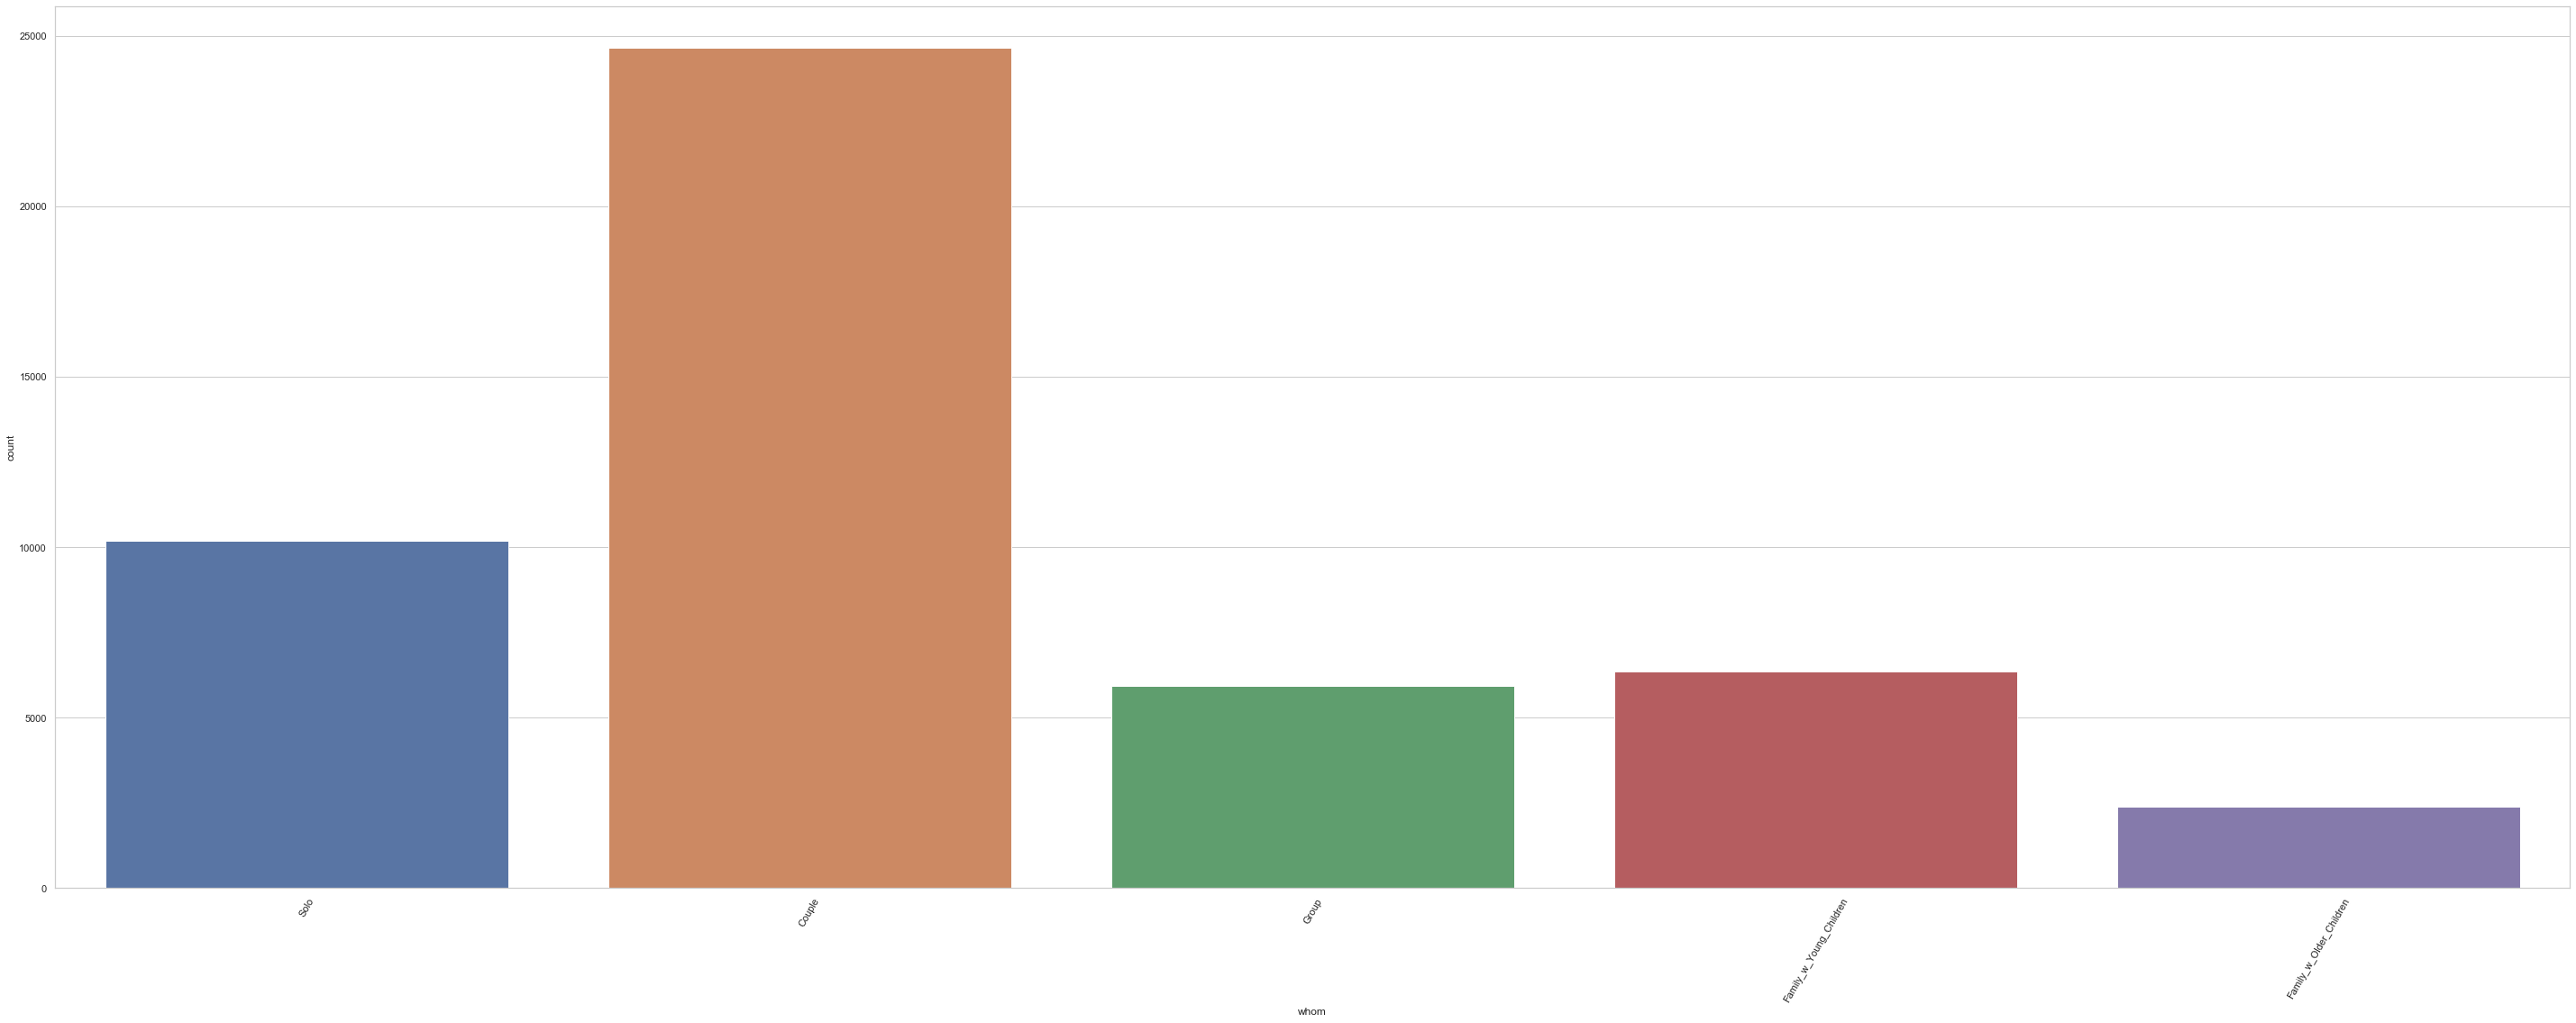

In [145]:
#Whom
ff=sns.countplot(df_top20['whom'])
who = ['Solo', 'Couple', 'Group', 'Family_w_Young_Children', 'Family_w_Older_Children']
ff.set_xticklabels(who)
plt.xticks(rotation=60)

# Further Analysis on Average Scores of Top 20 Hotels and Purpose of visiting these Hotels

In [146]:
df2 = df_top20[['Hotel_Name', 'Average_Score', 'Trip_type']]

In [147]:
df3= df2.groupby(['Hotel_Name','Average_Score']).size().reset_index(name='Count').sort_values(['Hotel_Name','Count'],ascending=[1,0]).groupby('Average_Score').head(20)

In [148]:
df5= df2.groupby(['Hotel_Name','Trip_type']).size().reset_index(name='Count').sort_values(['Hotel_Name','Count'],ascending=[1,0]).groupby('Trip_type').head(20)

In [78]:
df3 = df3.sort_values(by=('Count'), ascending = False)

In [79]:
df5 = df5.sort_values(by=('Count'), ascending = False)

In [80]:
df4 = df3.head(20)

In [81]:
df6 = df5.head(20)

In [82]:
import plotly.express as px 
fig = px.bar(df4, x='Hotel_Name', y='Average_Score', title='Average Scores of the Top 20 Hotels') 
fig.show()

In [83]:
fig = px.bar(df6, x="Hotel_Name", y='Count', color="Trip_type", title="Purpose of the Visitors Coming to the Top 20 Hotels")
fig.show()

# **NLP**

We will further expand the text analysis by introducing sentiment analysis. Customers reviews are highly linked to how they felt about their stay at the hotel. For this purpose we are using Vader, which is a part of the NLTK library. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
-a neutrality score
-a positivity score
-a negativity score
-an overall score that summarizes the previous scores.
We will integrate those 4 values as features in our dataset
*Please note that this part of the analysis is inspired from the following sources:
*[5]:https://gist.github.com/jonathanoheix/3030a082a22f3c2f733ca26f9781e7d2#file-nlp5-py
*[6]:https://www.kaggle.com/jonathanoheix/sentiment-analysis-with-hotel-reviews
*[7]:https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [149]:
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [150]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [151]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_cleaned"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_cleaned"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [152]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_cleaned"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [153]:
reviews_df.head()

review  is_bad  \
425257   Close to Las Ramblas but a bit of a seedy are...       0   
507589                            Clean and good location       0   
219228   Fantastic hotel in the heart of Shoreditch a ...       0   
205533   Not clean Smelly rooms Cigarette Smoke Towels...       1   
216690   Nothing  I liked everything thats why keep co...       0   

                                           review_cleaned    neg    neu  \
425257  close las ramblas bite seedy area night modern...  0.000  0.806   
507589                                clean good location  0.000  0.263   
219228  fantastic hotel heart shoreditch stone throw d...  0.000  0.722   
205533  clean smelly room cigarette smoke towel change...  0.158  0.842   
216690            nothing like everything thats keep come  0.189  0.811   

          pos  compound  nb_chars  nb_words  doc2vec_vector_0  ...  \
425257  0.194    0.5927        94        22          0.108011  ...   
507589  0.737    0.6808        24         5         -0.040507  ...   
219228  0.278    0.9413       265        50          0.006606  ...   
205533  0.000   -0.3089        85        14         -0.047607  ...   
216690  0.000   -0.3252        72        15          0.068224  ...   

        word_wonderful  word_work  word_world  word_worn  word_worth  \
425257             0.0        0.0         0.0        0.0         0.0   
507589             0.0        0.0         0.0        0.0         0.0   
219228             0.0        0.0         0.0        0.0         0.0   
205533             0.0        0.0         0.0        0.0         0.0   
216690             0.0        0.0         0.0        0.0         0.0   

        word_would  word_wrong  word_year  word_yet  word_young  
425257         0.0         0.0        0.0       0.0         0.0  
507589         0.0         0.0        0.0       0.0         0.0  
219228         0.0         0.0        0.0       0.0         0.0  
205533         0.0         0.0        0.0       0.0         0.0  
216690         0.0         0.0        0.0       0.0         0.0  

[5 rows x 1148 columns]

In [154]:
reviews_df.shape

(5152, 1148)

In [155]:
reviews_df.head()

review  is_bad  \
425257   Close to Las Ramblas but a bit of a seedy are...       0   
507589                            Clean and good location       0   
219228   Fantastic hotel in the heart of Shoreditch a ...       0   
205533   Not clean Smelly rooms Cigarette Smoke Towels...       1   
216690   Nothing  I liked everything thats why keep co...       0   

                                           review_cleaned    neg    neu  \
425257  close las ramblas bite seedy area night modern...  0.000  0.806   
507589                                clean good location  0.000  0.263   
219228  fantastic hotel heart shoreditch stone throw d...  0.000  0.722   
205533  clean smelly room cigarette smoke towel change...  0.158  0.842   
216690            nothing like everything thats keep come  0.189  0.811   

          pos  compound  nb_chars  nb_words  doc2vec_vector_0  ...  \
425257  0.194    0.5927        94        22          0.108011  ...   
507589  0.737    0.6808        24         5         -0.040507  ...   
219228  0.278    0.9413       265        50          0.006606  ...   
205533  0.000   -0.3089        85        14         -0.047607  ...   
216690  0.000   -0.3252        72        15          0.068224  ...   

        word_wonderful  word_work  word_world  word_worn  word_worth  \
425257             0.0        0.0         0.0        0.0         0.0   
507589             0.0        0.0         0.0        0.0         0.0   
219228             0.0        0.0         0.0        0.0         0.0   
205533             0.0        0.0         0.0        0.0         0.0   
216690             0.0        0.0         0.0        0.0         0.0   

        word_would  word_wrong  word_year  word_yet  word_young  
425257         0.0         0.0        0.0       0.0         0.0  
507589         0.0         0.0        0.0       0.0         0.0  
219228         0.0         0.0        0.0       0.0         0.0  
205533         0.0         0.0        0.0       0.0         0.0  
216690         0.0         0.0        0.0       0.0         0.0  

[5 rows x 1148 columns]

In [156]:
reviews_df['is_bad'].value_counts(normalize = True)

0    0.661491
1    0.338509
Name: is_bad, dtype: float64

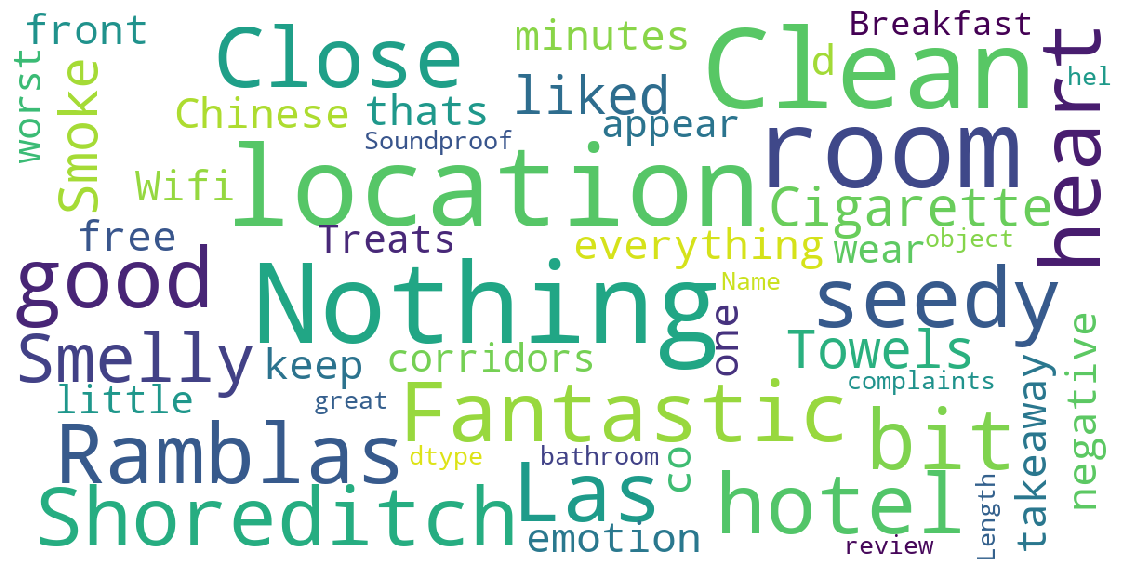

In [157]:
#Building wordcloud for all 50% of the reviews, for all of the hotels

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

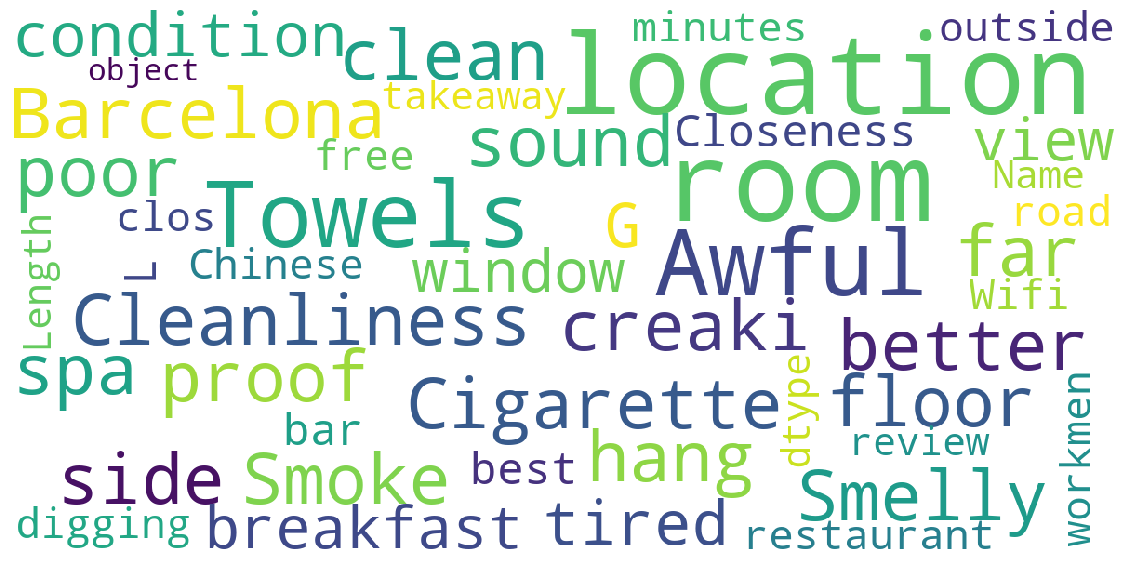

In [158]:
#Building wordcloud for all negative reviews, for all of the hotels

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df[reviews_df['is_bad']==1]['review'])

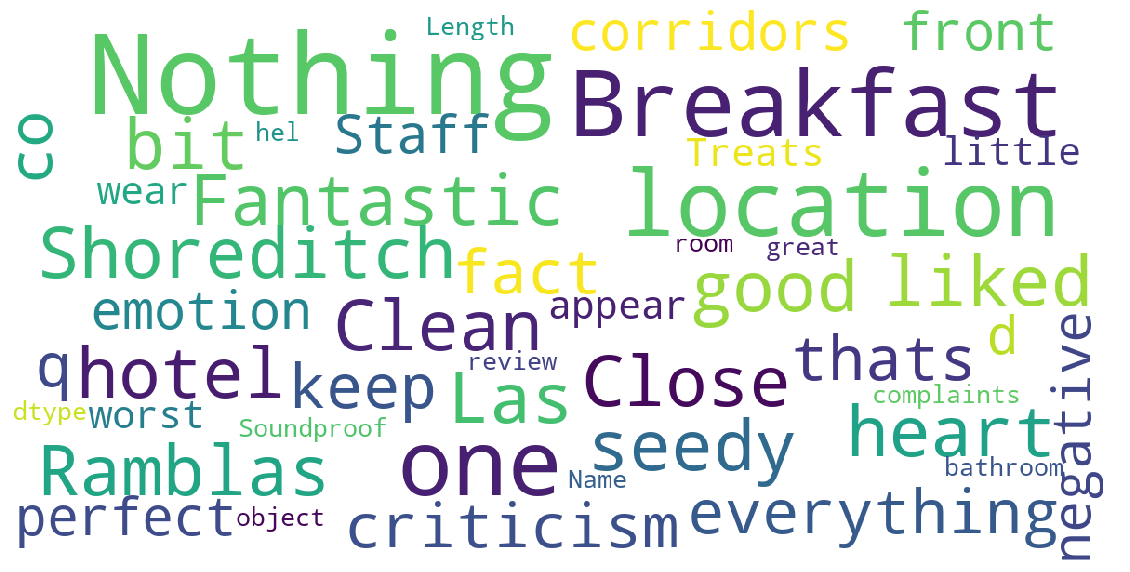

In [159]:
#Building wordcloud for all positive reviews, for all of the hotels

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df[reviews_df['is_bad']==0]['review'])


# NLP for TOP 20 Hotels Specifically

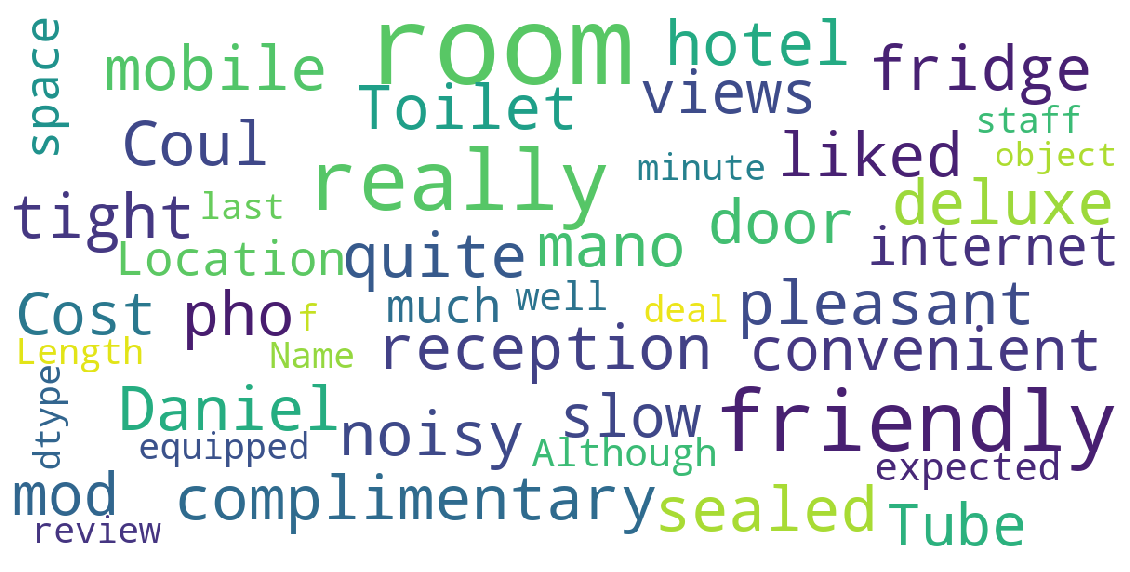

In [160]:
#Let's filter the df_reviews on top 20 hotels only:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df_top20['review'])



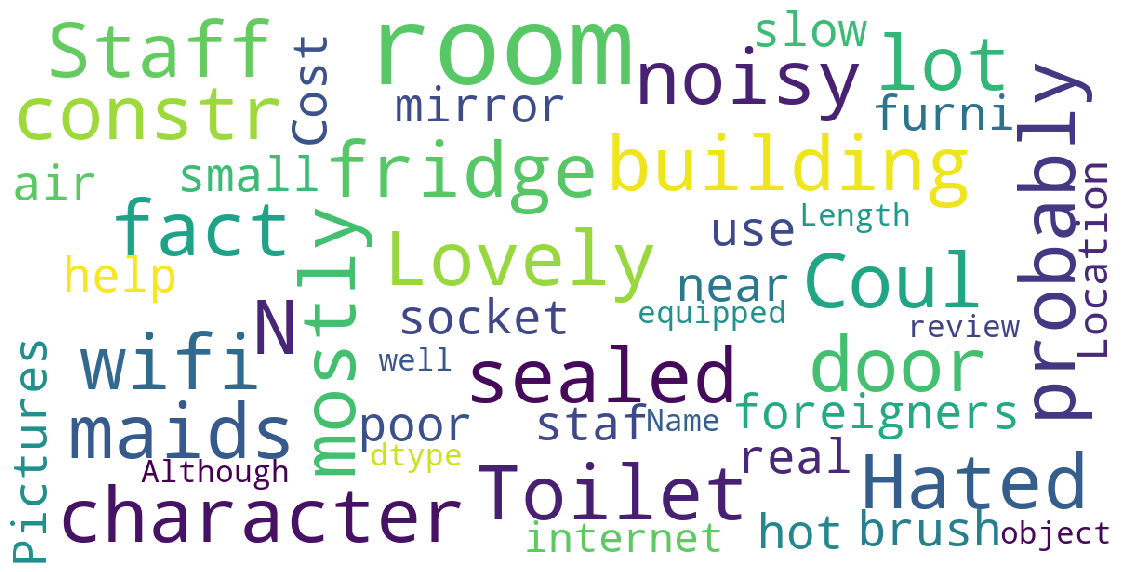

In [161]:
#Let's filter the negative df_reviews on top 20 hotels only:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df_top20[reviews_df_top20['is_bad']==1]['review'])


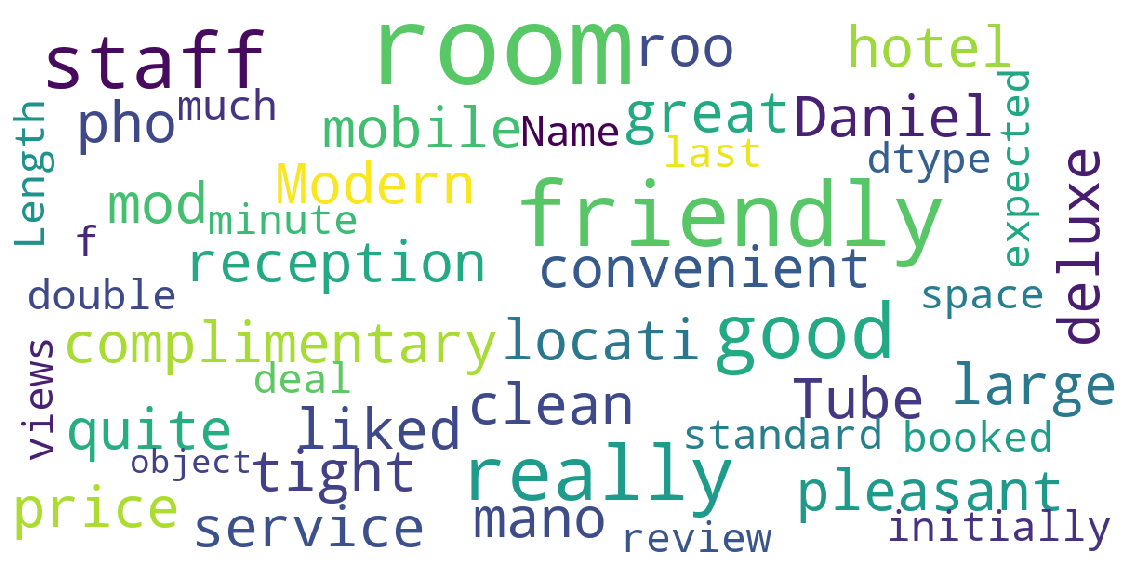

In [162]:
#Let's filter the postive df_reviews on top 20 hotels only:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df_top20[reviews_df_top20['is_bad']==0]['review'])


# **Random Forests Classification Modelling**

In [163]:
#Creating the training and testing splits

label = 'is_bad' 
ignore_columns = [label, 'review', 'review_cleaned'] 
features = [c for c in reviews_df.columns if c not in ignore_columns]

X_train, X_test, y_train, y_test= train_test_split(reviews_df[features], reviews_df[label], test_size=0.2, random_state=42)

Please note that we have been inspired from the resource number [7], [8] in the pdf report of this code when building some pieces of the following code:

>1, train: 0.835, test: 0.695
>2, train: 0.843, test: 0.681
>3, train: 0.868, test: 0.701
>4, train: 0.907, test: 0.718
>5, train: 0.907, test: 0.752
>6, train: 0.913, test: 0.733
>7, train: 0.922, test: 0.754
>8, train: 0.927, test: 0.757
>9, train: 0.930, test: 0.753
>10, train: 0.941, test: 0.749
>11, train: 0.931, test: 0.737
>12, train: 0.938, test: 0.744
>13, train: 0.936, test: 0.749
>14, train: 0.919, test: 0.747
>15, train: 0.941, test: 0.752
>16, train: 0.938, test: 0.747
>17, train: 0.943, test: 0.765
>18, train: 0.942, test: 0.766
>19, train: 0.947, test: 0.770
>20, train: 0.959, test: 0.755
>21, train: 0.956, test: 0.758
>22, train: 0.950, test: 0.755
>23, train: 0.949, test: 0.764
>24, train: 0.953, test: 0.766
>25, train: 0.952, test: 0.770
>26, train: 0.951, test: 0.760
>27, train: 0.945, test: 0.759
>28, train: 0.958, test: 0.758
>29, train: 0.950, test: 0.763


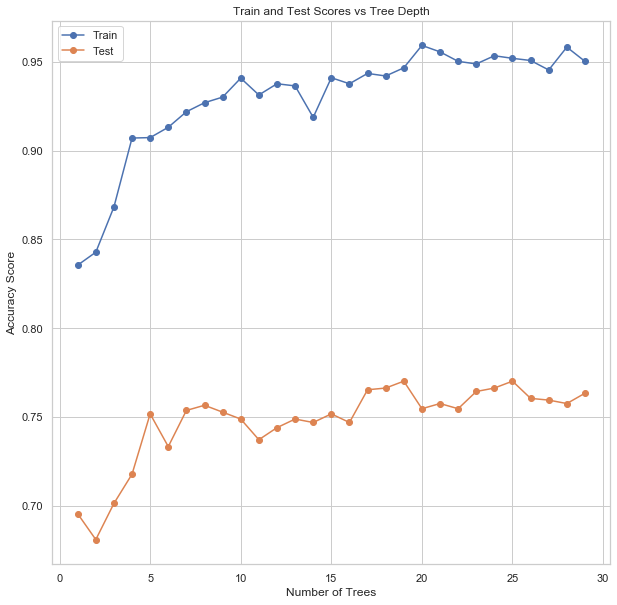

In [176]:
# train and evaluate a decision tree for each depth and number of trees

n_estimators = [i for i in range(1, 31)]

train_scores, test_scores = list(), list()
for j in n_estimators:
    # configure the model
    model = RandomForestClassifier(max_depth=30, n_estimators=j)
    # fit model on the training dataset
    model.fit(X_train, y_train)
    s=model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (j, train_acc, test_acc))
        
# plot of train and test scores vs tree depth

pyplot.figure(figsize=(10,10))
pyplot.plot(n_estimators,train_scores, '-o', label='Train')
pyplot.plot(n_estimators,test_scores, '-o', label='Test')
pyplot.legend()
pyplot.xlabel('Number of Trees')
pyplot.ylabel('Accuracy Score')
pyplot.title('Train and Test Scores vs Number of Trees with Maximum Depth of 30')
pyplot.show()
    


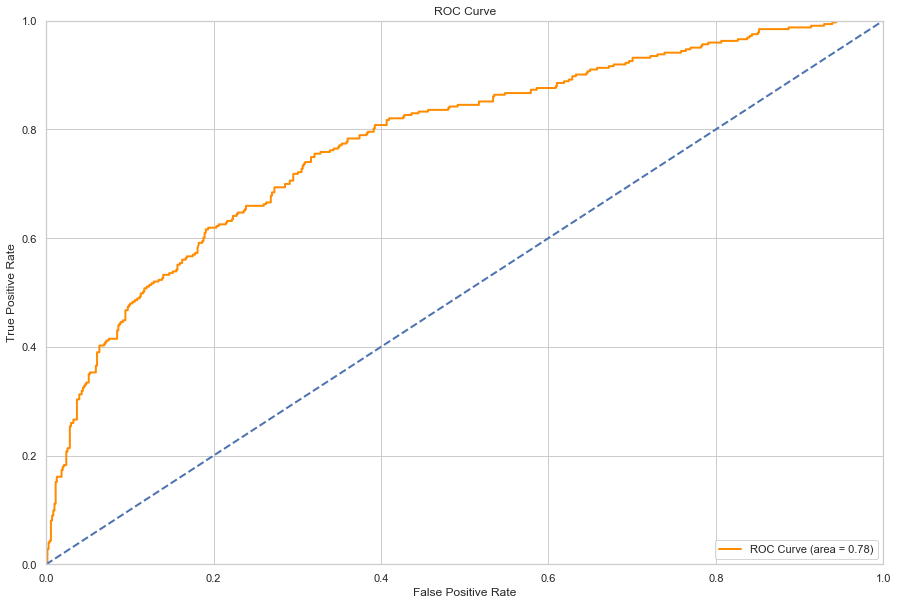

In [177]:
#Evaluating the model using ROC curve, AUC, precision and recall scores
y_pred = [x[1] for x in model.predict_proba(X_test)]
fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr,tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color ='darkorange',
        lw = lw, label = 'ROC Curve (area = %0.2f)' % roc_auc)

plt.plot([0,1], [0,1], lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show()

In [183]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.64


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.64')

<Figure size 1440x1440 with 0 Axes>

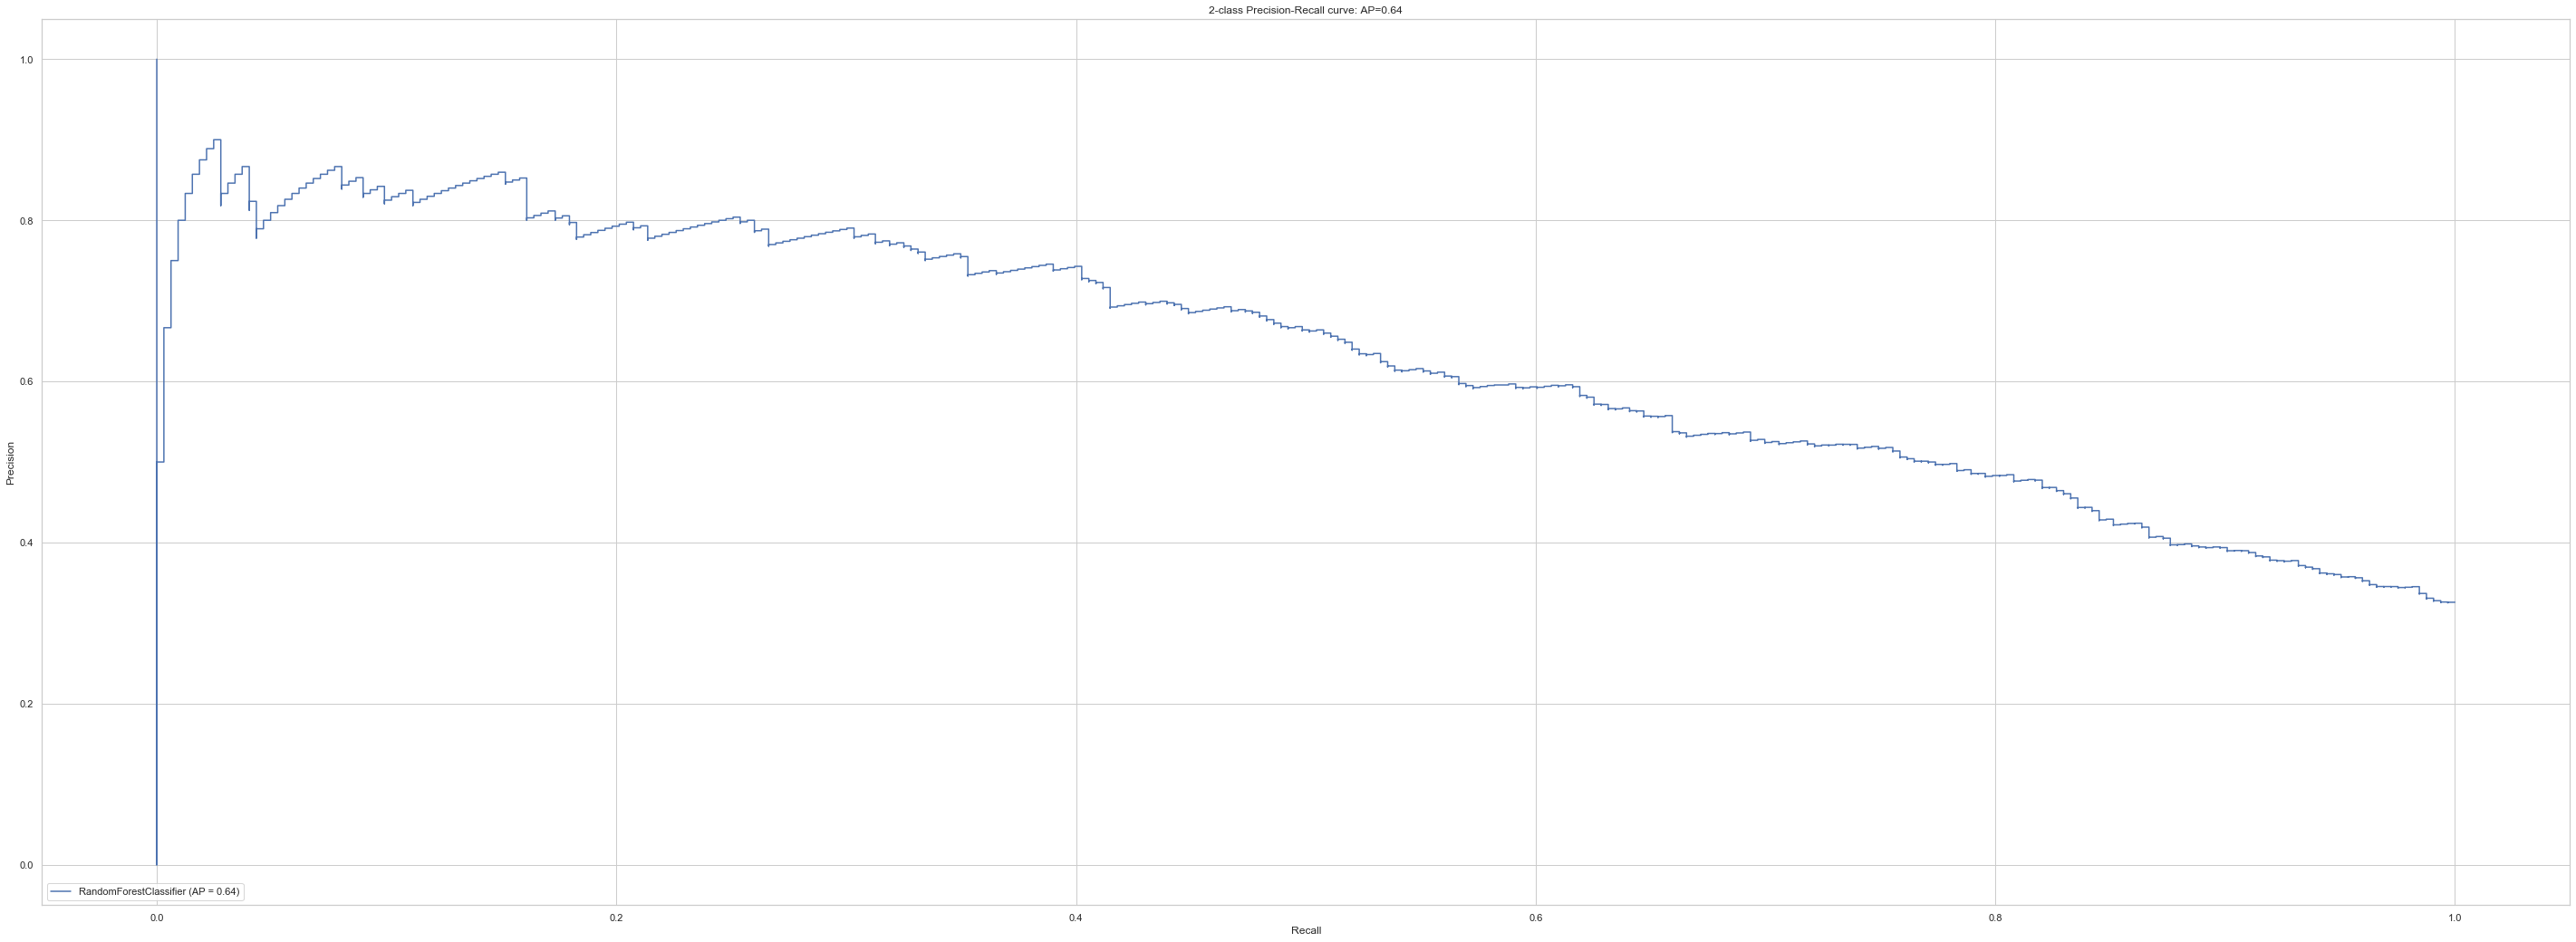

In [185]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
